# <center>Milestone 2</center> 

> This notebook contains initial analyses and data processing for our project, aiming to investigate how society is reflected in cinema.

## Table of Contents
* [1. Data Loading and Preprocessing](#1-data-loading-and-preprocessing)
    * [1.1 Data Loading](#11-data-loading)
    * [1.2 Initial Data Preprocessing](#12-initial-data-preprocessing)
    * [1.3 Enrichment of the Movie Dataset](#13-enrichment-of-the-Movie-Dataset)
* [2. General Statistics about the Movie Dataset](#2-general-statistics-about-the-movie-dataset)
    * [2.1 Total Number of Movies](#21-total-number-of-movies)
    * [2.2 Number of Years and Movies per Year](#22-number-of-years-and-movies-per-year)
    * [2.3 NaN Value Analysis](#23-nan-value-analysis)
    * [2.4 Number of Languages](#24-number-of-languages)
    * [2.5 Number of Countries and World Regions](#25-number-of-countries-and-world-regions)
    * [2.6 Number of Genres and Genre Categories](#26-number-of-genres-and-genre-categories)

* [3. Movies Association to Historical Events and Movements](#3-movies-association-to-historical-events-and-movements)
    * [3.1 Creation of Dictionaries](#31-creation-of-dictionaries)
    * [3.2 Match Movie to Event](#32-match-movie-to-event)
    * [3.3 Quality Check of Dictionaries](#33-quality-check-of-dictionaries)
        * [3.3.1 Correlation Matrix](#331-correlation-matrix)
        * [3.3.2 Movies Shared Between Two Events](#332-movies-shared-between-two-events)
        * [3.3.3 Evaluation using a Test Set](#333-evaluation-using-a-test-set)
            * [3.3.3.1 Test Set and Classification](#3331-test-set-and-classification)
            * [3.3.3.2 Percentage of Correct Matching](#3332-percentage-of-correct-matching)
            * [3.3.3.3 Performance Statistics of Classification](#3333-performance-statistics-of-classification)

* [4. Diving into the Analysis of Events](#4-diving-into-the-analysis-of-events)
    * [4.1 Number of Movies per Event Over the Years](#41-number-of-movies-per-event-over-the-years)
    * [4.2 Number of Countries producing a Movie Matched to an Event](#42-number-of-countries-producing-a-movie-matched-to-an-event)
    * [4.3 Analysis Box Office Revenue](#43-analysis-box-office-revenue)
    * [4.4 Analysis of Ratings](#44-analysis-of-ratings)
    * [4.5 Analysis of Number of Rating Votes](#45-analysis-of-number-of-rating-votes)
    * [4.6 Analysis of Popularity](#46-analysis-of-popularity)
    * [4.7 Sentiment Analysis using Reviews](#47-sentiment-analysis-using-reviews)



In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import re
import matplotlib.cm as cm
from dateutil.relativedelta import relativedelta
from scipy.stats import f_oneway
from scipy import stats
from sklearn.metrics import confusion_matrix
from collections import Counter

# Additional functions

from helpers import*

## 1. Data Loading and Preprocessing

### 1.1 Data Loading

> We start with loading the CMU Movies Summary Corpus datasets, obtained from [this source](http://www.cs.cmu.edu/~ark/personas/), along with additional datasets necessary to complement our collection, for [reviews](https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp?select=reviews.csv) and for [ratings and revenues](https://www.kaggle.com/datasets/ebiswas/imdb-review-dataset).



In [2]:
# Paths

DATA_PATH = "data/"


# Specific paths for CMU Movies Summary Corpus datasets

MOVIES_FOLDER = DATA_PATH + "MovieSummaries/"
MOVIES_DATASET = MOVIES_FOLDER + "movie.metadata.tsv"
CHARACTERS_DATASET = MOVIES_FOLDER + "character.metadata.tsv"
CHARACTERS_NAMES_DATASET = MOVIES_FOLDER + "name.clusters.txt"
CHARACTERS_TYPES_DATASET = MOVIES_FOLDER + "tvtropes.clusters.txt"
PLOTS_DATASET = MOVIES_FOLDER + "plot_summaries.txt"


# Specific paths for additional datasets to complement the CMU Movies Summary Corpus datasets

ADDITIONAL_FOLDER = DATA_PATH + "AdditionalDatasets/"
IMDB_DATASET = ADDITIONAL_FOLDER + "imdb_movies.csv"
REVIEWS_DATASET = ADDITIONAL_FOLDER + "movies_events_reviews.csv"

In [3]:
# Loading of the CMU Movies Summary Corpus datasets

movies = pd.read_csv(MOVIES_DATASET, sep = '\t', names = ['id_wiki', 'id_freebase', 'name', 'date', 'box_office', 'runtime', 'lang', 'country', 'genre'])
characters = pd.read_csv(CHARACTERS_DATASET, sep = '\t', names = ['id_wiki_movie', 'id_freebase_movie', 'movie_release_date', 'character_name', 'actor_birth_date', 'actor_gender', 'actor_height', 'actor_ethnicity_freebase_id', 'actor_name', 'actor_age_movie_release', 'character_actor_freebase_map_id', 'character_id_freebase', 'actor_id_freebase'])
characters_names = pd.read_csv(CHARACTERS_NAMES_DATASET, sep = '\t', names = ['character_name', 'character_actor_freebase_map_id'])
characters_types = pd.read_csv(CHARACTERS_TYPES_DATASET, sep = '\t', names = ['character_type', 'character_actor_freebase_map_id'])
plot_summaries = pd.read_csv(PLOTS_DATASET, sep = '\t', names = ['id_wiki_movie', 'summary'])


# Loading of additional Review dataset 

movies_events_reviews = pd.read_csv(REVIEWS_DATASET)

> As we need plot summaries for our movie analysis strategy, we merge the plot summaries with the movies dataset now. 
>Since we are executing an inner merge, we simultaneously eliminate any movies that might lack subplots.

In [4]:
movies_df = movies.copy() 
movie_plots = plot_summaries.copy()


# Merging movie and plot_summaries datasets

movies_and_plots = pd.merge(movies_df, movie_plots, how = 'inner', left_on = 'id_wiki', right_on = 'id_wiki_movie').copy()


print("The shape of the movie dataframe before:", movies_df.shape, "; and the shape of the merged dataframe containing movie plots:", movies_and_plots.shape)

The shape of the movie dataframe before: (81741, 9) ; and the shape of the merged dataframe containing movie plots: (42204, 11)


### 1.2 Initial Data Preprocessing

> In order to explore the dataset, some of the data in the movies dataset has to be preprocessed, because it is not in a format we can use. This is the case for the movie release date, the movie genres, the countries of production and the movie languages.
>
>We convert the movie release date to datetime format (we decided to only keep the years for our analysis).
>
>In order to make data handling easier we convert the dictionaries to a list, keeping only the names (not the id) for the columns 'genre', 'country' and 'language'. 

In [5]:
# THIS CELL SHOULD BE RUN ONLY ONCE

movies_and_plots['date'] = pd.to_datetime(movies_and_plots['date'], errors = 'coerce', format = 'mixed').dt.year

movies_and_plots['genre'] = movies_and_plots['genre'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_and_plots['country'] = movies_and_plots['country'].copy().apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_and_plots['lang'] = movies_and_plots['lang'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

### 1.3 Enrichment of the Movie Dataset

>To address the high NaN rate in the 'box_office' column, we enrich this column with an additional dataset, obtained on [Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). We also merge the following columns to our dataset: 'vote_average', 'vote_count' and 'popularity'.

In [6]:
imdb_df = pd.read_csv(IMDB_DATASET, dtype={'column_name': str}, low_memory=False)

In [7]:
# This dataset only contains imdb_ids, while the current dataset we are working with doesn't have them
# So we have to create a DataFrame with 2 columns: one for imdb_ids, the other for corresponding freebase_ids

id_translations = translations_imbd_to_freebase()  
revenue_df_with_freebase_ids = pd.merge(imdb_df, id_translations, on = 'imdb_id', how = 'left') 


# Selectionning only the columns of interest

revenue_freebase = revenue_df_with_freebase_ids[['id_freebase', 'revenue']].copy()

In [8]:
# Create a mapping dictionary from 'id_freebase' to 'revenue'

revenue_mapping = revenue_freebase.set_index('id_freebase')['revenue'].to_dict()


# Fill NaN values in 'box_office' with corresponding values from 'revenue' 

movies_box_office_filled = movies_and_plots.copy()
movies_box_office_filled['box_office'] = movies_box_office_filled['box_office'].combine_first(movies_box_office_filled['id_freebase'].map(revenue_mapping))


#Create the new columns 'vote_average', 'vote_count' and 'popularity'

In [9]:
nan_count_before = movies_and_plots['box_office'].isnull().sum()
print(f'Before filling with the column "revenue": Nans {nan_count_before}')

nan_count_after = movies_box_office_filled['box_office'].isnull().sum()
print(f'After filling with the column "revenue": Nans {nan_count_after}')
print(f"The new NaN percentage is {nan_count_after / movies_box_office_filled.shape[0] * 100:.1f}%, before it was: {nan_count_before / movies_box_office_filled.shape[0] * 100:.1f}%,")

Before filling with the column "revenue": Nans 34617
After filling with the column "revenue": Nans 21006
The new NaN percentage is 49.8%, before it was: 82.0%,


> We were able to add about 13'000 new 'box_office' values. Despite still having 50% NaN values, this marks a significant improvement compared to the initial 83%.

In [10]:
# Process and merge the columns 'vote_average', 'vote_count' and 'popularity' with the movies_box_office_filled

imdb_ratings_popularity_df = imdb_df.copy()
imdb_ratings_popularity_df.drop(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'original_title', 'title', 'original_language', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'video'], axis=1, inplace=True)


# Merging the dataframe containing popularity and vote_average with the dataframe containing the freebase id translations

imdb_ratings_popularity_freebaseid_df = pd.merge(imdb_ratings_popularity_df, id_translations, on='imdb_id', how='left')


# Merging the previous dataframe with the dataframe of all movies contained in at least one event (movies_events_df)

movies_merge_df = movies_box_office_filled.copy()
imdb_ratings_popularity_events_df = pd.merge(movies_merge_df, imdb_ratings_popularity_freebaseid_df, on='id_freebase', how='left')
imdb_ratings_popularity_events_df.drop(['imdb_id'], axis=1, inplace=True)

In [11]:
movies_enriched_df = imdb_ratings_popularity_events_df.copy() #We will work with this dataframe from now on


## 2. General Statistics about the Movie Dataset

> The aim of this section is to explore the size of our enriched movie dataset from section 1.3 and get a sense of its scope.

### 2.1 Total Number of Movies

>In order to know the size of the dataset we print the number of movies.

In [12]:
print("The total number of movies is :", movies_enriched_df.shape[0])

The total number of movies is : 42220


### 2.2 Number of Years and Movies per Year

> In order to see the timeframe of the dataset we print the number of years covered and analyze the number of movies released per year.

In [13]:
print("Movie release years range: ", movies_enriched_df['date'].min(), "-", movies_enriched_df['date'].max())

Movie release years range:  1893.0 - 2014.0


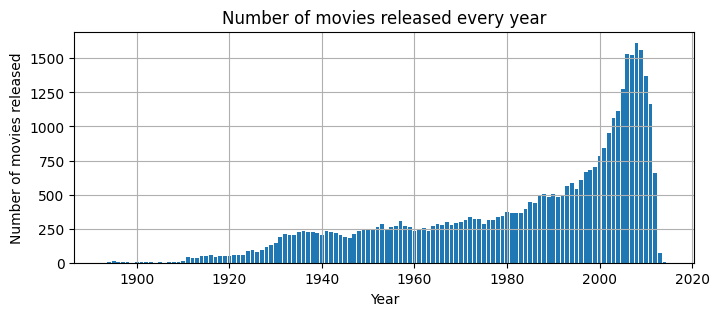

In [14]:
# Calculate the number of movies per year

movies_per_year = movies_enriched_df['date'].value_counts()


# Plot the number of movies per year

plt.figure(figsize = (8, 3))
plt.bar(movies_per_year.index, movies_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year')
plt.grid(True)
plt.show()

> The dataset spans an entire century of cinema, providing a promising opportunity for our exploration of the impact specific events or movements had on society. 

### 2.3 NaN Value Analysis

> Here we analyze the NaN Values in the movies dataset, and the relevant columns in the imdb and reviews dataset.

In [15]:
# Printing NaN values, counts and percentages in the movies' dataset for further analysis

movies_nan_analysis_df = movies_enriched_df.copy()

print("MOVIES' DATASET: \n")
compute_nan_count_and_percentage(movies_nan_analysis_df)

MOVIES' DATASET: 

id_wiki: 0 NaN values, which represents 0.00 % of the column.

id_freebase: 0 NaN values, which represents 0.00 % of the column.

name: 0 NaN values, which represents 0.00 % of the column.

date: 2619 NaN values, which represents 6.20 % of the column.

box_office: 21006 NaN values, which represents 49.75 % of the column.

runtime: 6626 NaN values, which represents 15.69 % of the column.

lang: 0 NaN values, which represents 0.00 % of the column.

country: 0 NaN values, which represents 0.00 % of the column.

genre: 0 NaN values, which represents 0.00 % of the column.

id_wiki_movie: 0 NaN values, which represents 0.00 % of the column.

summary: 0 NaN values, which represents 0.00 % of the column.

popularity: 21607 NaN values, which represents 51.18 % of the column.

vote_average: 21607 NaN values, which represents 51.18 % of the column.

vote_count: 21607 NaN values, which represents 51.18 % of the column.



> While the majority of our columns have a low count of NaN values, we can notice that some columns show a high proportion of NaN values in their data, such as 'box_office', 'popularity', 'vote_average' and 'vote_count'. We have decided that 50% is sufficient to represent the other 50% of movies, to show that our principle works. However, for Milestone 3, we will have to evaluate whether to import a more complete dataset.

In [16]:
# Printing NaN values, counts and percentages in the reviews dataset for further analysis

reviews_nan_analysis_df = movies_events_reviews[['review_summary', 'review_detail']].copy()

print("REVIEWS' DATASET: \n")
compute_nan_count_and_percentage(reviews_nan_analysis_df)

REVIEWS' DATASET: 

review_summary: 38344 NaN values, which represents 90.85 % of the column.

review_detail: 38344 NaN values, which represents 90.85 % of the column.



> There is a high proportion of NaN values in reviews' data. However, we decided to pursue the emotions' assessment in reviews since we have around 4000 films with reviews and there is not many datasets on the web linking reviews' texts with movies' titles. However, we need to take this into account when drawing conclusions.

### 2.4 Number of Languages


> Here we analyze the number of languages spoken in movies.

In [17]:
# Making one big list with all instances of all languages

languages_list = []
for lang in movies_enriched_df['lang'] : languages_list += lang


# Number of different languages (tranforming the list into a set)

tot_languages = len(set(languages_list))

print('The total number of languages represented in the dataset is :', tot_languages)

The total number of languages represented in the dataset is : 208


In [18]:
# Looking for outliers contained in the "lang" column

languages_list_unique = list(set(languages_list))
print(languages_list_unique[:20])

['Swahili Language', 'Mende Language', 'Arabic Language', 'Standard Cantonese', 'Silent film', 'Bulgarian Language', 'Afrikaans Language', 'American Sign Language', 'Chhattisgarhi Language', 'Bosnian language', 'Hopi Language', 'Apache, Western Language', 'Australian English', 'Scottish Gaelic language', 'Turkish Language', 'Krio Language', 'Estonian Language', 'Saami, North Language', 'Romani language', 'Belarusian language']


>We looked at each element, here are some important observations of the column 'lang':
>- Some entries are not languages in the traditional sense but rather countries such as 'France', 'Hungary' and 'Japan'
>- Important to notice is that some languages may be the same but described differently for different movies (e.g. 'german' vs 'deutsch')
>- Some languages when described in their own language use a different alphabet, e.g. '𐐖𐐲𐑉𐑋𐑌𐐲'
>- When a film is a silent film this is marked by the entry 'silent film'
>- Contains invalid values such as 'a' (this is because here we have not dropped the NAN's and 'n' and 'a' are recognized as individual languages).

### 2.5 Number of Countries and World Regions

>We analyzed the individual countries present in the dataset.
>
> We want to define different world regions, grouping different countries together in order to make data handling and visualizations easier. We could define the following regions: 
>- Europe 
>- USA + Canada 
>- Australia + Oceania
>- Middle East
>- Asia
>- Africa
>- South & Central America

In [19]:
# Obtain a list of countries contained in the dataset

only_countries = movies_enriched_df['country'].copy()
only_countries = only_countries.to_list()


# Removing all Nan's and making a onedimensional list of all countries contained in the dataset

only_countries = [x for x in only_countries if x != "NaN"]
only_countries = [item for sublist in only_countries for item in sublist]


# Creating a list with all unique countries contained in the dataset

only_countries_unique = get_unique_countries(only_countries)


print(only_countries_unique[:20])

['United States of America', 'United Kingdom', 'Germany', 'South Africa', 'Turkey', 'German Democratic Republic', 'India', 'Australia', 'New Zealand', 'Netherlands', 'Mexico', 'Canada', 'Brazil', 'Poland', 'Spain', 'Argentina', 'Japan', 'South Korea', 'Hungary', 'Pakistan']


In [20]:
# Create the corresponding regions for later analysis containing all countries from the dataset
# The individual countries come from the variable 'only_countries_unique'

europe_countries =  ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime']
middle_east_countries = ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan']
asia_countries = ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma']
africa_countries = ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau']
south_central_america_countries =  ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba']
north_america_countries = ['United States of America', 'Canada']
australia_countries = ['Australia', 'New Zealand']
outlier_countries = [ 'German Language', 'Malayalam Language'] 


# Check that all countries in the dataset are contained in a certain region


all_countries = europe_countries + middle_east_countries + asia_countries + africa_countries + south_central_america_countries + north_america_countries + australia_countries + outlier_countries
print('Number of countries in the newly defined world regions:',len(only_countries_unique))
print('Number of countries in the dataset:', len(all_countries))

Number of countries in the newly defined world regions: 147
Number of countries in the dataset: 147


>A movie can be produced by multiple countries at the same time
>
> In the entries of some countries, there are typos or different syntax which is why these countries are not considered identical. To avoid any effects this can have, all manners of which the country was written was included in the grouping. Examples of this are:
> - “Ukrainian SSR” vs “Ukranian SSR”
> - “Socialist Federal Republic of Yugoslavia” vs “Yugoslavia” vs “Federal Republic of Yugoslavia”
>- “Palestinian territories” vs “Palestinian Territories”
>
>There are a few entries which do not correspond to countries. These were grouped into the list "outlier_countries" and will not be used for country analysis, as we cannot be completely sure what countries produced them. Examples of this are:
> - “German Language”
>  - “Malayalam Language”

> In order to facilitate access to the world regions we add them to the dataset.

In [21]:
regions = {'europe_countries': europe_countries, 'middle_east_countries': middle_east_countries, 'asia_countries': asia_countries, 
           'africa_countries': africa_countries, 'south_central_america_countries': south_central_america_countries, 'north_america_countries': north_america_countries, 'australia_countries': australia_countries, 'outlier_countries': outlier_countries}


# Create a new column 'world_region' in the DataFrame

movies_with_regions = movies_enriched_df.copy()
movies_with_regions['world_region'] = movies_with_regions['country'].apply(find_region, regions = regions)
movies_with_regions.sample()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,summary,popularity,vote_average,vote_count,world_region
31770,2498402,/m/02p6jcj,Once Upon a Time in China VI,1997.0,0.0,94.0,"[Standard Cantonese, Standard Mandarin, Englis...","[Hong Kong, China]","[Adventure, World cinema, History, Action/Adve...",2498402,"Wong Fei-hung, Clubfoot and 13th Aunt cross th...",2.383612,5.7,23.0,asia_countries


> Now, we can plot the number of movies released for each world region over the years.

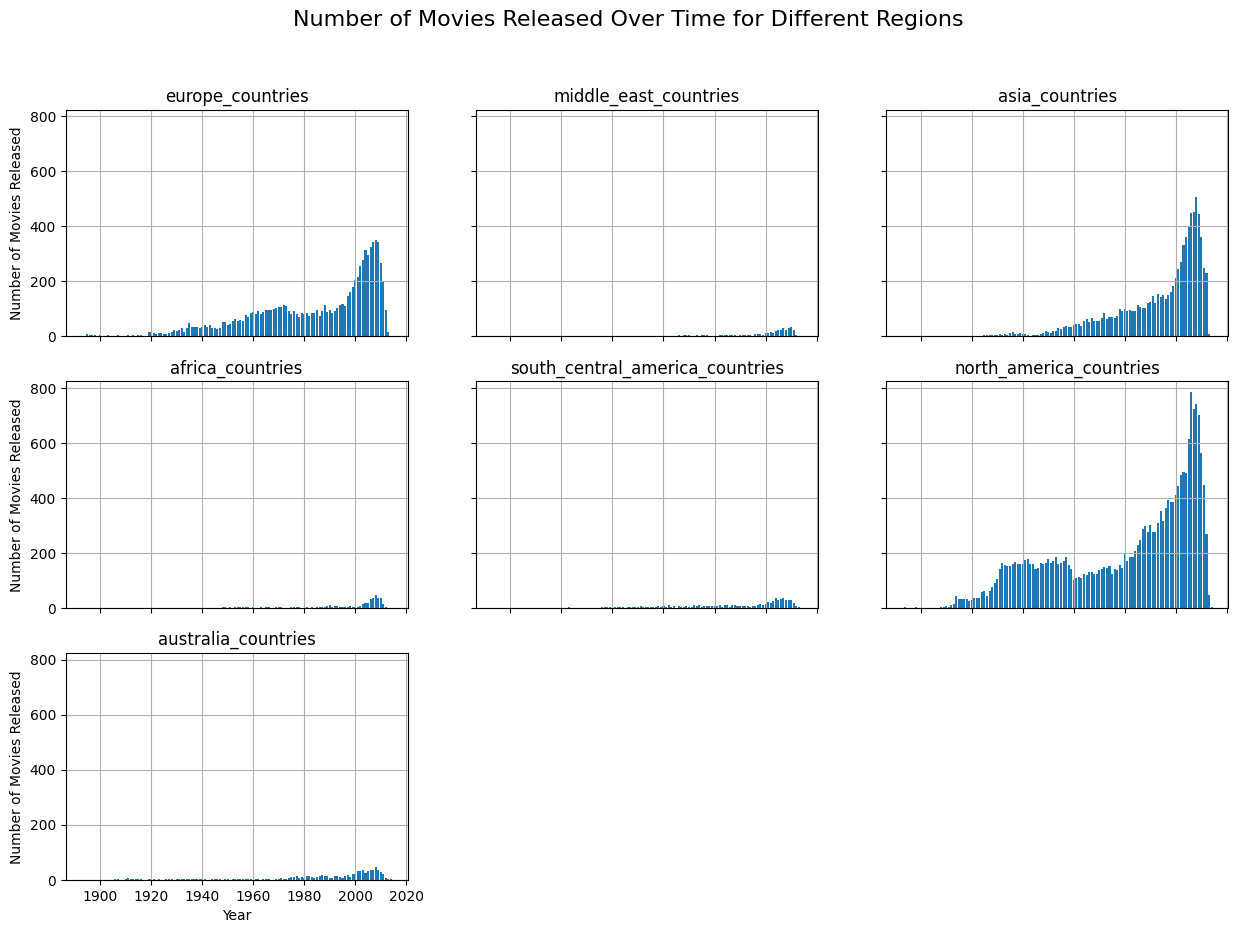

In [22]:
# Create subplots

fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Number of Movies Released Over Time for Different Regions', fontsize=16)


# Iterate over regions and plot the number of movies released over time

for (region, countries), ax in zip(regions.items(), axs.flatten()):
    filtered_movies = movies_with_regions[movies_with_regions['country'].apply(lambda x: any(item in x for item in countries))]
    movies_per_year = filtered_movies['date'].value_counts().sort_index()
    ax.bar(movies_per_year.index, movies_per_year.values)
    ax.set_title(region)


# Subplots layout

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Number of Movies Released')
    ax.grid(True)
    ax.label_outer()

fig.delaxes(axs[2][2])
fig.delaxes(axs[2][1])

plt.show()

> North American, European, and Asian countries are the top three producers in this dataset. The Middle East, Africa, South America and Australia exhibit lower film production.

### 2.6 Number of Genres and Genre Categories

>We analyzed the individual countries present in the dataset. 
>
>We want to define different genre categories, grouping different movie genres together in order to make data handling and visualizations easier.

In [23]:
# Explode the 'genre' column to create individual rows for each genre

movies_dataframe_genre = movies_with_regions.explode('genre').copy()


# Check how many unique genre we have

unique_genres = movies_dataframe_genre['genre'].unique()
print('Total number of unique genres : ',unique_genres.shape[0])
print('Examples of genres are : ', unique_genres[:10])

Total number of unique genres :  364
Examples of genres are :  ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Erotic thriller' 'Psychological thriller' 'Drama']


> Since there are 364 different genres, we decided to create genre categories in order to better understand and visualize the genre column more easily.

In [24]:
# Defining overcategories of genres

action = ['Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Film noir', 'Neo-noir', 'Ninja movie', 'Superhero', 'Superhero movie', 'Samurai cinema','Apocalyptic and post-apocalyptic fiction', 'Doomsday film', 'Movies About Gladiators', 'Spy']
adult = ['Adult', 'Erotic Drama', 'Erotic thriller', 'Erotica', 'Gay pornography', 'Hardcore pornography', 'Homoeroticism', 'Pinku eiga', 'Pornographic movie', 'Pornography', 'Softcore Porn'] 
adventure = ['Action/Adventure', 'Adventure', 'Adventure Comedy', ' Costume Adventure', 'Family-Oriented Adventure', 'Fantasy Adventure', 'Sci-Fi Adventure', 'Wuxia']
animation = ['Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Clay animation', 'Computer Animation', 'Silhouette animation', 'Stop motion']
comedy = ['Action Comedy', 'Adventure Comedy', 'Black comedy', 'Comdedy', 'Comedy', 'Comedy Thriller', 'Comedy Western', 'Comedy film', 'Comedy horror', 'Comedy of Errors', 'Comedy of manners', 'Comedy-drama', 'Crime Comedy', 'Domestic Comedy', 'Ealing Comedies', 'Fantasy Comedy', 'Gross out', 'Gross-out film', 'Heavenly Comedy', 'Horror Comedy', 'Humour', 'Media Satire', 'Musical comedy', 'Parody', 'Political satire', 'Romantic comedy', 'Satire', 'Screwball comedy', 'Sex comedy', 'Slapstick', 'Stand-up comedy', 'Tragicomedy', 'Workplace Comedy']
crime = ['Biker Film', 'Buddy cop', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Fiction', 'Crime Thriller', 'Detective', 'Detective fiction', 'Gangster Film', 'Giallo','Heist', 'Juvenile Delinquency Film', 'Law & Crime', 'Master Criminal Films', 'Mystery', 'Outlaw', 'Outlaw biker film', 'Prison', 'Prison escape', 'Prison film', 'Statutory rape', 'Whodunit']
documentary = ['Archives and records', 'Biographical film', 'Biography', 'Biopic [feature]','Culture & Society', 'Essay Film', 'Docudrama', 'Documentary', 'Education', 'Mondo film', 'Educational', 'Environmental Science', 'Film & Television History', 'Finance & Investing', 'Health & Fitness', 'Historical Documentaries', 'Journalism', 'Language & Literature', 'Libraries and librarians', 'Linguistics', 'Media Studies', 'Mockumentary','Natural disaster', 'Nature', 'News', 'Political Documetary', 'Rockumentary', 'Travel', 'World History']
drama = ['Addiction Drama', 'Cavalry Film', 'Childhood Drama', 'Comedy-drama', 'Costume drama', 'Crime Drama', 'Docudrama', 'Drama', 'Erotic Drama', 'Family Drama', 'Fantasy Drama', 'Historical drama', 'Illnesses & Disabilities', 'Inspirational Drama', 'Legal drama', 'Marriage Drama', 'Melodrama', 'Medical fiction', 'Musical Drama', 'Political drama', 'Romantic drama', 'Tragedy']
family_and_children = ['Animals', 'Buddy Picture', 'Buddy film', 'Camp', "Children's", "Children's Entertainment", "Children's/Family", 'Christmas movie', 'Coming of age', 'Coming-of-age film','Dance', 'Family & Personal Relationships', 'Family film', 'Holiday Film', 'Interpersonal Relationships', 'Jukebox musical', 'Jungle Film', 'Backstage musical', 'Musical', 'Roadshow theatrical release', 'School story']
fantasy = ["Children's Fantasy", 'Creature Film', 'Fairy tale', 'Fantasy', 'Fantasy Adventure', 'Fantasy Comedy', 'Fantasy Drama', 'Heaven-Can-Wait Fantasies', 'Mythological Fantasy', 'Monster', 'Monster movie', 'Revisionist Fairy Tale', 'Romantic fantasy', 'Supernatural', 'Sword and sorcery', 'Sword and sorcery films', 'Vampire movies', 'Werewolf fiction', 'Zombie Film']
history = ['Archaeology', 'Archives and records', 'Avant-garde', 'British Empire Film', 'Cold War', 'Film & Television History', 'Gulf War', 'Hagiography', 'Historical drama', 'Historical Epic', 'Historical fiction', 'History', 'Movies About Gladiators', 'Period piece', 'Plague', 'Samurai cinema', 'Sword and Sandal', 'The Netherlands in World War II', 'World History']
horror = ['Comedy horror', 'Costume Horror', 'Demonic child', 'Gothic film', 'Haunted House Film', 'Horror', 'Horror Comedy', 'Natural horror films', 'Period Horror', 'Psycho-biddy', 'Psychological horror', 'Road-Horror', 'Sci-Fi Horror', 'Slasher', 'Splatter film', 'Supernatural', 'Zombie Film', 'Z movie']
oldies = ['Black-and-white', 'Goat gland', 'Silent film', 'Pre-Code']
romance = ['Chick flick','Romance Film', 'Romantic comedy', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
science_fiction = ['Alien Film', 'Alien invasion','Computers', 'Dystopia', 'Future noir', 'Inventions & Innovations', 'Sci Fi Pictures original films', 'Sci-Fi Adventure', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Science Fiction', 'Science fiction Western', 'Tokusatsu', 'Space opera', 'Space western', 'Time travel']
thriller = ['Action Thrillers', 'Chase Movie', 'Comedy Thriller', 'Crime Thriller', 'Political thriller', 'Psychological thriller', 'Romantic thriller', 'Sci-Fi Thriller', 'Thriller']
war = ['Anti-war', 'Anti-war film', 'Cold War', 'Combat Films', 'Gulf War', 'Nuclear warfare', 'Private military company', 'The Netherlands in World War II', 'War effort', 'War film']
western = ['Acid western', 'B-Western', 'Comedy Western', 'Epic Western', 'Hybrid Western', 'Indian Western', 'Revisionist Western', 'Science fiction Western', 'Singing cowboy', 'Space western', 'Spaghetti Western', 'Western']
lgbtq_and_gender = ['Feminist Film', 'Gay',  ' Gay Interest', 'Gay Themed', 'Gay pornography', 'Gender Issues', 'Homoeroticism', 'LGBT', 'New Queer Cinema', 'Women in prison films']

number_genres_considered = action + adult + adventure + animation + comedy + crime + documentary + drama + family_and_children + fantasy + history + horror + oldies + romance + science_fiction + thriller + war + western + lgbtq_and_gender
print('The ratio of genres considered', len(number_genres_considered), '/', unique_genres.shape[0])


# Check how many movies are covered by these genres

represented_movies = movies_dataframe_genre[movies_dataframe_genre['genre'].apply(lambda x: any(item in x for item in number_genres_considered))]
represented_movies_unique = represented_movies['name'].unique()
print('Movies considered:', len(represented_movies_unique), 'out of', movies_with_regions.shape[0])

The ratio of genres considered 292 / 364
Movies considered: 38351 out of 42220


> We decided to retain only a subset of genres, specifically a ratio of 292 out of 364 possible genres. 
>
>Some genres in the dataset are irrelevant for a study on society, such as 'Short Films', which essentially represent a distinct movie categorization rather than a genre.
>
> Due to this, however, a significant number of movies fall outside the scope of the considered genres. We made an effort to include as many genres in the list as possible while maintaining as much objectivity as possible. For example, the genre 'Heist' could be part of the 'drama', 'comedy' or 'crime' categories. However, the only one of these where it will always be part of is the 'crime' category so we only matched it to this one.
>
>Additionally, there are genres that encompass two of our selected overarching genres, such as 'Adventure Comedy.' In these cases, we added them to both overarching genres. 

> In order to facilitate access to the world regions we add them to the dataset. The movies not considered in our study will have a NaN value in this new column.

In [25]:
genres_considered = {'action': action, 'adult': adult, 'adventure': adventure, 'animation': animation, 'comedy': comedy, 'crime': crime, 'documentary': documentary, 'drama': drama, 'family_and_children': family_and_children, 'fantasy': fantasy, 'history': history, 'horror': horror, 'oldies': oldies, 'romance': romance, 'science_fiction': science_fiction, 'thriller': thriller, 'war': war, 'western': western, 'lgbtq_and_gender': lgbtq_and_gender}


# Add a new column to the main dataframe to store the names of the genres and make them easily accessible

movies_with_genre = movies_with_regions.copy()
movies_with_genre['new_genre'] = None


# Iterate over genres_considered and update the 'new_genre' column

for name, genre_list in genres_considered.items():
    mask = movies_with_genre['genre'].apply(lambda x: any(item in x for item in genre_list))
    movies_with_genre.loc[mask, 'new_genre'] = movies_with_genre.loc[mask, 'new_genre'].apply(lambda x: [] if x is None else x)  # Initialize with an empty list if None
    movies_with_genre.loc[mask, 'new_genre'] = movies_with_genre.loc[mask, 'new_genre'].apply(lambda x: x + [name] if isinstance(x, list) else [name])
    
movies_with_genre.sample()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,summary,popularity,vote_average,vote_count,world_region,new_genre
35013,1775698,/m/05vzpg,"Jamón, jamón",1992.0,0.0,94.0,[Spanish Language],[Spain],[Comedy],1775698,"Silvia, a beautiful girl, prepares omelettes f...",4.117851,6.2,60.0,europe_countries,[comedy]


> Now, we can plot the distributions of genre categories over time. We have chosen to group them by decade for better visualization.

/tmp/ipykernel_1392/4145682675.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c', len(genre_counts.columns))


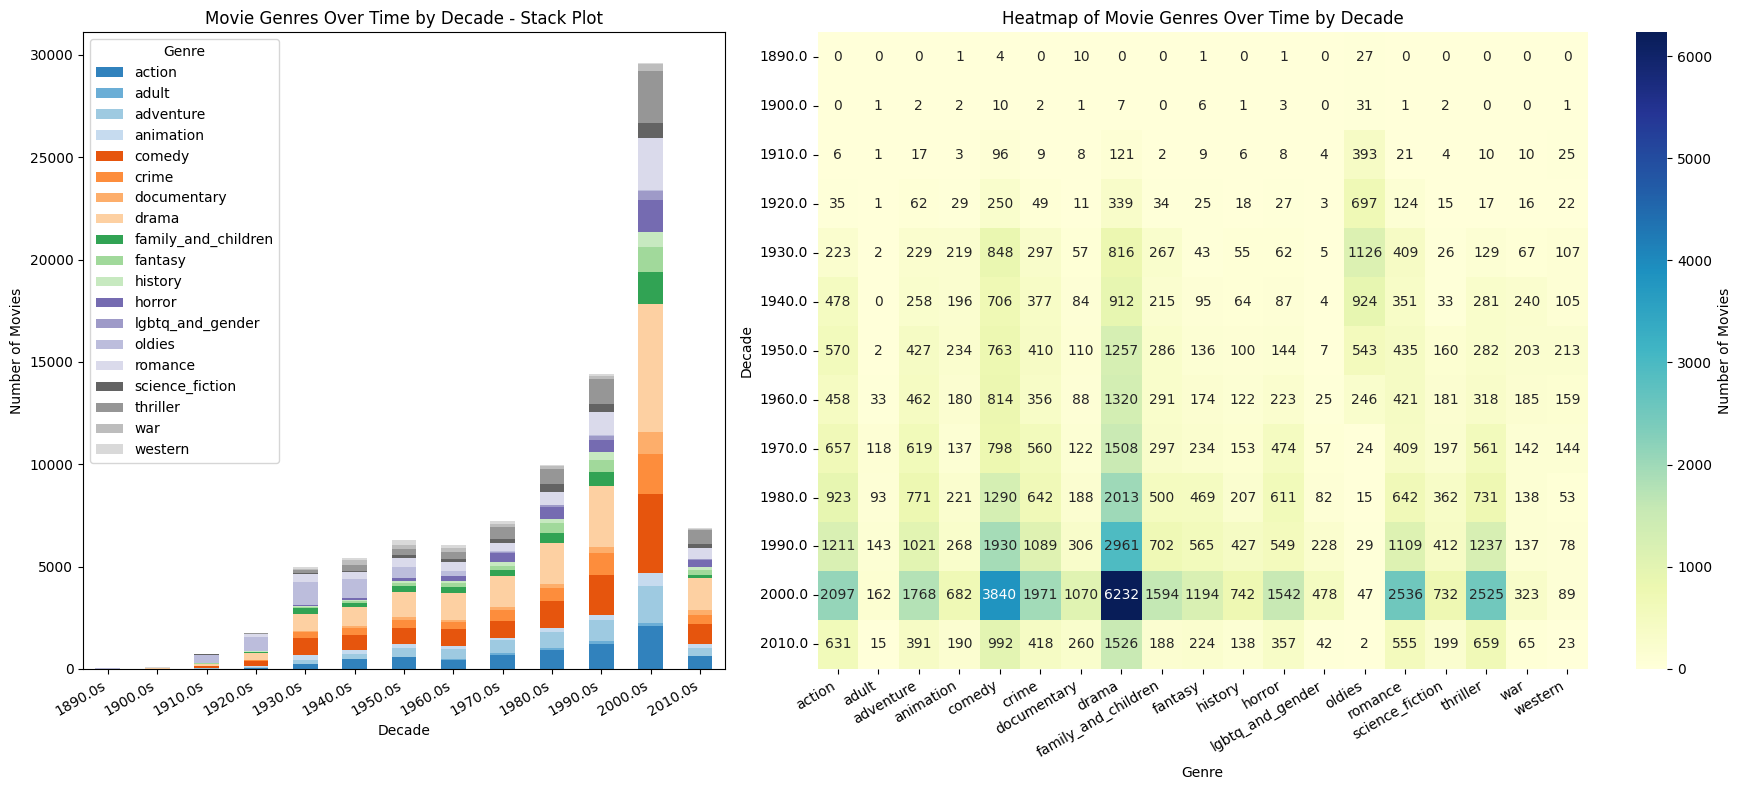

In [26]:
movies_dataframe = movies_with_genre.copy()


# Create a new column representing the corresponding decade of each movie for easier plotting

movies_dataframe['decade'] = (movies_dataframe['date'] // 10) * 10


# Count occurrences of each genre per decade

df_stacked = movies_dataframe[['decade', 'new_genre']].explode('new_genre')
genre_counts = df_stacked.groupby(['decade', 'new_genre']).size().unstack(fill_value=0)


# Plot

fig, axes = plt.subplots(1, 2, figsize = (18, 8), gridspec_kw = {'width_ratios': [2, 3]})

cmap = cm.get_cmap('tab20c', len(genre_counts.columns))
colors = {genre: cmap(i) for i, genre in enumerate(genre_counts.columns)}

genre_counts.plot(kind = 'bar', stacked = True, ax = axes[0], color = colors)
x_labels = ['{}s'.format(decade) for decade in genre_counts.index]
axes[0].set_xticklabels(x_labels, rotation = 30, ha = 'right')
axes[0].set_title('Movie Genres Over Time by Decade - Stack Plot')
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Number of Movies')
axes[0].legend(title='Genre', loc='upper left')

sns.heatmap(genre_counts, cmap = "YlGnBu", annot = True, fmt = 'd', cbar_kws = {'label': 'Number of Movies'}, ax = axes[1])
axes[1].set_title('Heatmap of Movie Genres Over Time by Decade')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Decade')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 30, ha = 'right')

plt.tight_layout()
plt.show() ;

> The overall number of movies has increased across decades, but variations exist among individual genres. Notably, the 'oldies' genre, encompassing silent and black-and-white films, shows a decline in its production proportion compared to other genres.
>
>Given that the dataset extends only until 2016, the observed general decrease in the number of movies for the last plotted decade might be influenced by the incomplete data for the most recent years.

## 3. Movies Association to Historical Events and Movements

> The focus of our project is to study how impactful historical events and movements are by analyzing movies. Initially, we attempted to categorize the movies to events based on their genres. However, leading our study solely according to the genres to which the movies belong to seems quite challenging, as genres may not accurately reflect historical events. 
>
> As a result, we have decided to adopt another approach by mapping movies to the historical events they correspond to through a keyword search in their plot summaries. The keywords specific to each event are defined in event-related dictionaries we created.
>
> In this part we will define our dictionaries, associate the movies in our dataset to the different events using these dictionaries and evaluate the quality of our dictionary-based classification model.

### 3.1 Creation of Dictionaries

> We decided to focus our study on several different events and movements that dominated the past century: 
>- World War 1
>- World War 2
>- Space race
>- The Cold War
>- The Vietnam War
>- Women emancipation
>- Black history
>- Digitalisation
>- Sexuality
>- The emergence of STDs
>- The Opioid Crisis
>- Destigmatizing Mental Health
>- The Atomic Bomb
>- The emergence of Genetic Engineering
>- LGBTQ emancipation
>- Terrorism
>
>The dictionaries are defined below and were inspired by content found on the [internet](https://www.oed.com/discover/word-lists). 
>
>Note : We tried to stay as objective and event-specific as possible but since the dictionaries were made manually we cannot exclude some potential bias.

In [27]:
# World War 1 dictionary

ww1_dict = ['world war i', 'world war 1', 'ww1', 'wwi', '1914', '1916', '1917', '1918', 'the great war', 'verdun', 'somme', 'mustard gas', 'no man\'s land', 'armistice', 'trenches', 'trench', 'treaty of versailles', 'colonial troops', 'franz ferdinand', 'wilson', 'lusitania', 'central powers', 'league of nations', '1915', 'spanish flu', 'spanish influenza', 'first world war']


# World War 2 dictionary 

ww2_dict = ['world war ii', 'world war 2', 'ww2', 'wwii', '1939', '1940', '1941', '1942', '1943', '1944', '1945', 'axis powers', 'allied powers', 'hitler', 'churchill', 'roosevelt', 'stalin', 'holocaust', 'pearl harbor', 'hiroshima', 'nagasaki', 'nazis', 'nazi', 'concentration camps', 'fascism', 'fascist', 'dunkirk', 'atomic bomb', 'nuclear', 'united nations', 'enigma code', 'd-day', 'reich', 'marshall plan', 'gestapo', 'deportation', 'auschwitz', 'swastika', 'ss', 'blitzkrieg', 'stalingrad', 'internment camps', 'manhattan project', 'nuremberg trials', 'luftwaffe', 'the big three']


# Space Exploration dictionary 

space_dict = ['moon landing', '1969', 'apollo 11', 'apollo', 'space race', 'neil armstrong', 'buzz aldrin', 'michael collins', 'lunar module', 'command module', 'lunar surface', 'moon mission', 'lunar landing', 'astronauts', 'astronaut', 'flag planting', 'apollo program', 'spaceflight', 'saturn 5', 'saturn v', 'laika', 'moonwalk', 'moon rover', 'spacecraft', 'nasa', 'solar system', 'mars', 'satellite', 'satellites', 'international space station', 'iss', 'yuri gagarin', 'gagarin', 'sputnik', 'mercury program', 'vostok program', 'luna program', 'space shuttle program', 'mir space station']


# Cold War dictionary

cold_war_dict = ['nuclear arms race', 'iron curtain', 'berlin airlift', 'proxy wars', 'proxy war', 'proxy states',  'cuban missile', 'cuban revolution', 'berlin wall', 'mccarthyism', 'mutual assured destruction', 'warsaw pact', 'north atlantic treaty organization', 'sputnik', 'perestroika', 'glasnost', 'helsinki accords', 'truman doctrine', 'huac', 'house un-american activities committee', 'korean war', 'gorbachev', 'khrushchev', 'kennedy', 'stalin', 'nixon', 'truman', 'johnson', 'saigon', 'agent blue', 'agent orange', 'paris peace accords', 'napalm', 'mutually assured destruction', 'mutually-assured destruction', 'mi5', 'soviet union', 'ussr', 'mutual defense assistante act', 'nuclear deterrence', 'olympic boycott', 'olympic boycotts', ' ostpolitik', 'brandt', 'reagan', 'red scare', 'russification', 'south-east asia treaty organisation', 'seato', 'sovietisation', 'stasi', 'tet', 'checkpoint charlie', 'cold war', 'east germany', 'west germany', 'iron curtain', 'gdr', 'frg', 'ddr', 'brd', 'reunification', 'space race', 'apollo program', 'apollo 11','atomic testing', 'arms race']


# Vietnam War dictionary

vietnam_war_dict = ['vietnam war', 'viet cong', 'viet', 'viets', 'agent orange', 'napalm', 'tet offensive', 'my lai massacre', 'hanoi', 'saigon', 'tonkin', 'paris peace accords', 'rolling thunder', 'agent blue', '1954', '1974', 'nixon']


# Women Emancipation dictionary 

women_emancipation_dict = ['feminism', 'suffrage', 'equal rights', 'gender equality', "women's liberation", 'female empowerment', 'female emancipation', 'gender roles', "women's rights", 'glass ceiling', 'patriarchy', 'sexism', 'feminist', 'abortion', 'women in the workplace', 'equal pay', 'maternity leave', 'body positivity', 'sexual harassment', 'sexist', 'gender wage gap', 'gender discrimination', 'domestic violence', "women's march", 'gender stereotypes', 'gender bias', 'empowering', "women's health", 'contraceptive pill', 'birth-control', 'gender inequality', 'contraception', 'wage gap', 'gender pay gap', 'seneca falls', 'suffragist', 'suffragists', 'feminists', 'reproductive rights', 'international women’s day', 'roe v. wade', 'birth control', 'gender gap', "women’s abilities", 'female engineer', 'female mathematician', 'first woman', 'first female', 'gender inequality', 'macho', 'veil']


# Black History dictionary

black_history_dict = ['black history', 'slavery', 'emancipation proclamation', 'underground railroad', 'jim crow laws', 'segregation', 'montgomery bus boycott', 'martin luther king jr.', 'rosa parks', 'malcolm x', 'black panthers', 'frederick douglass', 'harriet tubman', 'sojourner truth', 'booker t. washington', 'w.e.b. du bois', 'civil rights act', 'voting rights act', 'black power', 'african american culture', 'harlem renaissance', 'great migration', 'tuskegee airmen', 'buffalo soldiers', 'negro league baseball', 'black lives matter', 'kwanzaa', 'haitian revolution', 'madam cj walker', 'tuskegee experiment', 'zora neale hurston', 'shirley chisholm', 'octavius catto', 'black wall street', 'black liberation', 'slave rebellion', 'freedom riders', 'hip-hop', 'african diaspora', 'american civil war', 'kkk', 'ku klux klan', 'racism', 'racist', 'discrimination', 'segregate', 'segregated', 'colored facilities', 'first black', 'first african american', 'civil rights movement', 'martin luther king', 'juneteenth', 'slave', 'slaves', 'racists', 'apartheid', 'nelson mandela', 'mlk', 'black harlem', 'new negro movement']


# Digitalisation dictionary

digitalisation_dict = ['internet', 'drones', 'computer', 'mobile phone', 'web', 'robots', 'artificial intelligence', 'social media', 'hackers', 'laptop', 'screen', 'facebook', 'software', 'instagram', 'twitter', 'smartphone', 'computers', 'mobile phones', 'darkweb', 'google', 'microsoft', 'hacking', 'cybersecurity', 'cyber-attack', 'cyber attack', 'cybercrime', 'hacker']


# Sexuality dictionary

sexuality_dict = ['sexuality', 'gender expression', 'bdsm', 'safe sex', 'sexual health', 'sex education', 'reproductive rights', 'sex-worker', 'sexual empowerment', 'stripper', 'strip-club', 'strip club', 'sexual stigma', 'kink', 'fetish', 'polyamory', 'polygamy', 'monogamy', 'sexuality exploration', 'sexuality education', 'sexual liberation', 'pleasure activism', 'prostitute', 'sadism', 'condom', 'contraception', 'orgasm', 'masturbation', 'masturbating', 'jerking off', 'get laid', 'pornography', 'porno', 'porn', 'pornstar', 'anal', 'sextoy', 'dildo', 'libido', 'vulva', 'vagina', 'penis']


# STDs dictionary

STDs_dict = ['aids', 'hiv', 'human immunodeficiency virus', 'acquired immunodeficiency syndrome', 'antiretroviral therapy', 'hiv transmission', 'hiv testing', 'aids symptoms', 'hiv prevention', 'aids awareness', 'world aids day', 'aids activism', 'freddie mercury', 'hiv-positive', 'hiv-negative', 'sexually transmissible disease', 'std', 'syphilis', 'chlamydia', 'herpes', 'sexual health', 'gonorrhea', 'papillomavirus', 'cervical cancer', 'pelvic inflammatory disease', 'mycoplasma genitalium', 'uti', 'trichomoniasis', 'infertility', 'stds']


# Opioid crisis dictionary

opioid_crisis_dict = ['drug', 'opioid crisis', 'opioids', 'opioid', 'prescription painkillers', 'heroin', 'fentanyl', 'overdose', 'naloxone', 'substance abuse', 'pain management', 'methadone', 'morphine', 'buprenorphine', 'narcotic analgesics', 'overdosed', 'morphium', 'pain reliever', 'pain relievers', 'pain killer', 'pain killers', 'pain relief', 'syringe', 'syringes']


# Mental Health dictionary

mental_health_dict = ['psychoses', 'psychose', 'psychosis', 'schizophrene', 'schizophrenia', 'schizophrenic', 'psychiatrist', 'psychiatrists', 'psychiatric hospital', 'ptsd', 'post traumatic stress disorder', 'anxiety', 'shell shock', 'anti-depressants', 'depression', 'depressed', 'antidepressant', 'anti-depressant', 'antidepressants', 'bipolar disorder', 'bipolar', 'mental disorder', 'eating disorder', 'eating disorders', 'mental health', 'anorexia', 'burnout', 'burn-out', 'self harm', 'selfharm', 'self-harm', 'obsessive disorder', 'compulsive disorder', 'ocd', 'panic attack']


# Atomic Bomb dictionary

atomic_bomb_dict = ['manhattan project', 'oppenheimer', 'hiroshima', 'nagasaki', 'enola gay', 'trinity test', 'nuclear explosion', 'atomic testing', 'radiation effects', 'arms race', 'atomic bombings', 'fat man', 'nuclear chain reaction', 'nuclear', 'atomic']


# Genetic Engineering dictionary

genetic_engineering_dict = ['genetic', 'gene', 'genes', 'dna', 'genome', 'biotechnology', 'cloning', 'clone', 'clones', 'crispr-cas9', 'crispr', 'genetically modified', 'gmo', 'mutation', 'designer babies', 'gene therapy', 'stem cells', 'in vitro fertilization', 'ivf', 'in vitro', 'epigenetics', 'regenerative medicine', 'biohacking', 'in vivo']


# LGBTQIA+ dictionary

lgbtq_dict = ['gay', 'lesbian', 'lgbt pride', 'bisexual', 'drag queen', 'transexual', 'marriage equality', 'homosexual', 'coming out', 'homosexual rights', 'aids stigma', 'non binary', 'queer', 'freddie mercury', 'lgbtq+', 'two-spirit', 'transphobia', 'gender identity', 'lgbtqia+', 'transgender', 'gender fluid', 'asexual', 'pansexual', 'same-sex marriage', 'transsexual', 'non-binary', 'bisexuality', 'homosexuality', 'transsexuality', 'homophobia', 'homophobic', 'gender dysphoria', 'stonewall', 'lgbt', 'lgbtq', 'sexual orientation', 'drag show', 'drag performance', 'sex change', 'gender affirming surgery']


# Terrorism dictionary

terrorism_dict = ['terrorism', 'terrorist', 'terrorist attack', 'suicide bombing', 'suicide bomb', 'suicide bomber', '9-11', 'twin towers', 'hostage crisis', 'jihad', 'al-qaeda', 'bin laden', 'boeing 767', 'pentagon', 'flight 11', 'flight 175', 'flight 77', 'flight 93', 'hijacking', 'hijackers', 'hijacker', 'hijacked', 'isis', 'islamic state', 'explosive belt', 'counterterrorism', 'counter-terrorism', 'terrorists', 'nine eleven', 'september 11', 'homeland security', 'world trade center', 'north tower', 'south tower']

In [28]:
# List of events/movements and list of associated dictionaries

events = ['WW1', 'WW2', 'Space', 'Cold War', 'Vietnam war', 'Women emancipation', 'Black History', 'Digitalisation', 'Sexuality', 'STDs', 'Opioid Crisis', 'Mental Health', 'Atomic Bomb', 'Genetic Engineering', 'LGBTQ', 'Terrorism' ]
dictionaries = [ww1_dict, ww2_dict, space_dict, cold_war_dict, vietnam_war_dict, women_emancipation_dict, black_history_dict, digitalisation_dict, sexuality_dict, STDs_dict, opioid_crisis_dict, mental_health_dict, atomic_bomb_dict, genetic_engineering_dict, lgbtq_dict, terrorism_dict]
new_dictionaries = []


# Change the layout of the dictionaries to prepare for word search (replace `', '` with ` | `)

for el in dictionaries:
    for word in el:
        word = remove_punctuation(word) 
    new_dictionaries.append(' | '.join(el))


# Create a DataFrame for 'events' dictionaries

dictionaries_df = pd.DataFrame(list(zip(events, new_dictionaries)), columns=['events', 'dictionaries'])
dictionaries_df = dictionaries_df.set_index('events')

### 3.2 Match Movie to Event

> Our approach involves setting a threshold for each dictionary, indicating the minimum number of matching words required to classify a movie as belonging to an event. 
> Under the assumption that the dictionaries we are using are highly specific, we have set the threshold to 1 for all dictionaries. This means that one word is sufficient to match a movie plot to the corresponding event. We may adjust the thresholds later.
>
> After the matching, we check the number of movies matched to each event to make sure we have enough movies for the analysis to be representative.

In [29]:
# Set word search threshhold to 1 

dictionaries_df['threshold'] = 1

In [30]:
# This cell takes a little bit of time to run (around 4 minutes)


movies_events_df = movies_with_genre.copy()


# Matching each movie to one or multiple events

movies_events_df = add_event_columns(movies_events_df, dictionaries_df)
movies_events_df = create_events_belongs_to_column(movies_events_df, events)


# Creating a copy that we can use for further analyses (part 4) 

movies_events = movies_events_df.copy()

In [31]:
# Checking how many movies were associated to an event

movies_with_events_only = movies_events_df[movies_events_df[events].any(axis=1)].copy()
print('Number of movies that were successfully matched to at least one event : ', movies_with_events_only.shape[0])

movies_with_events_only.head(3)

Number of movies that were successfully matched to at least one event :  12848


,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,...,Digitalisation,Sexuality,STDs,Opioid Crisis,Mental Health,Atomic Bomb,Genetic Engineering,LGBTQ,Terrorism,events_belongs_to
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",975900,...,False,False,False,False,False,True,False,False,False,"[WW2, Space, Atomic Bomb]"
2,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],261236,...,False,True,False,False,False,False,False,False,False,[Sexuality]
6,18296435,/m/04cqrs4,Aaah Belinda,1986.0,NaN,NaN,[Turkish Language],[Turkey],[Comedy],18296435,...,False,False,False,False,True,False,False,False,False,[Mental Health]


>More than 12,000 movies out of 42,000 were selected to represent one or more historical events.

In [32]:
# Number of movies matched for each event

movies_per_event = {}

print('Number of movies matched to each event:')


# Iterate through each event

for event in events:
    movies_per_event[event] = movies_events_df[movies_events_df['events_belongs_to'].apply(lambda x: event in x)]

    print(f'{event}:', movies_per_event[event].shape[0])
    

Number of movies matched to each event:
WW1: 786
WW2: 2438
Space: 664
Cold War: 1070
Vietnam war: 323
Women emancipation: 614
Black History: 947
Digitalisation: 2275
Sexuality: 1694
STDs: 546
Opioid Crisis: 1690
Mental Health: 1619
Atomic Bomb: 610
Genetic Engineering: 484
LGBTQ: 1263
Terrorism: 823


>Looking at these numbers, we concluded that we have enough movies for each event-category to conduct a meaningful analysis.
>However, we should keep in mind that our dictionaries might be biased, which could also be reflected in the number of movies for each event. 

### 3.3 Quality Check of Dictionaries


>Now that we checked that the dictionary-based classification works, it is important to test the precision and accuracy of this categorization.
>
>To check how specific our dictionaries are, we will first look at the correlation between the different dictionaries and the number of movies that belong to two events at the same time. Keep in mind that this measure is not necessarily unwanted, as some movies might simply cover multiple topics. 
>
>Then we will test our dictionary-based classification on a subset of movies for which we know the corresponding event. This will allow us to assess the overall performance of our categorization through statistics that take into account False Positives, True Positives, False Negatives, and True Negatives.

#### 3.3.1 Correlation Matrix

>To evaluate our dictionaries, we create a correlation matrix using Pearson's Correlation. By doing this, we aim to ensure that no two dictionaries are too strongly correlated, which would indicate a lack of specificity. However, it is worth noting that some correlation might still make sense between two events, for example, for the events "Cold War" and "Vietnam War".

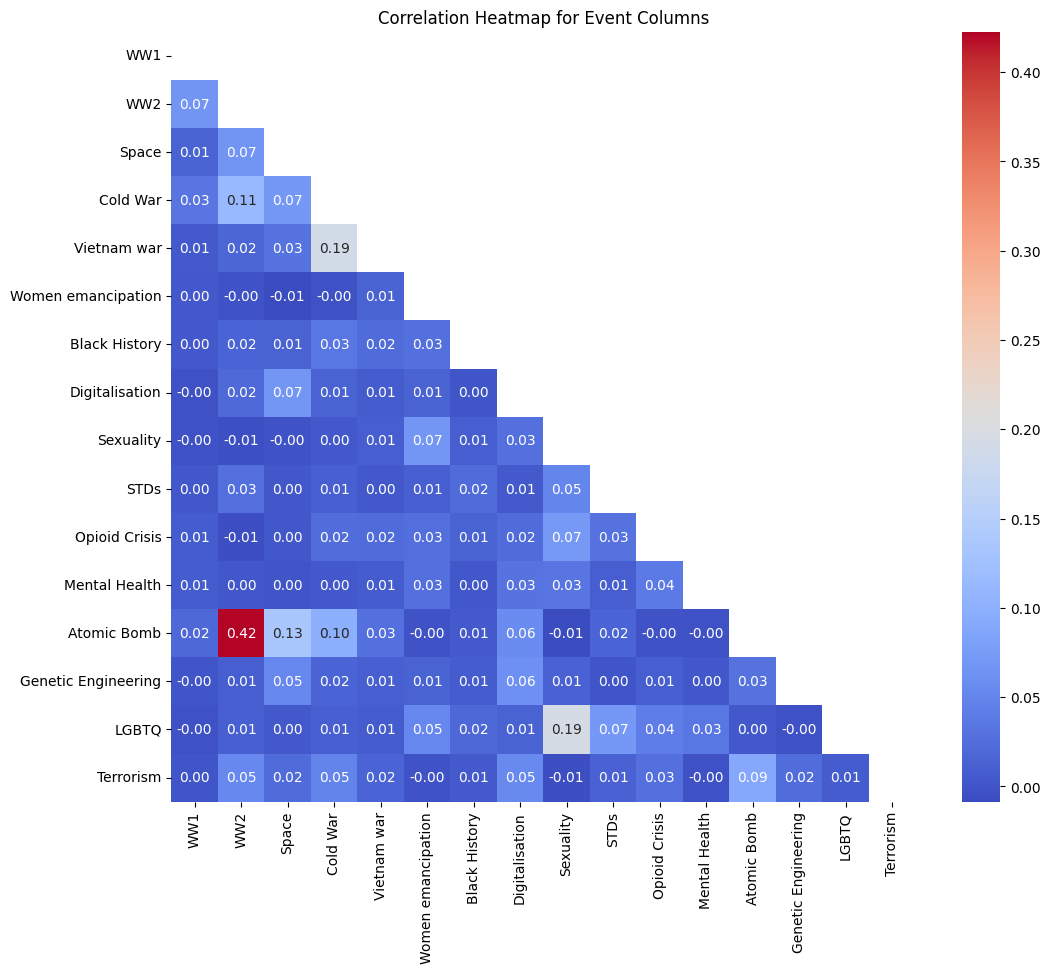

In [33]:
df = movies_events_df.copy()


# Create a correlation matrix

df[events] = df[events].astype(int)
correlation_matrix = df[events].corr()


# Create a mask for the upper triangle to reduce computation time

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))


# Plot the correlation matrix

plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", mask = mask)
plt.title("Correlation Heatmap for Event Columns")
plt.show()

>When looking at this correlation map, the most shared events among pairwise combinations of movies are:
>
>- Atomic Bomb & WW2
>- Atomic Bomb & Space
>- Cold War & Atomic Bomb
>- Cold War & Vietnam War
>- Sexuality & LGBTQ
>
>That is reasonable because those events are pairwise related. However, it is still a bit tricky to analyze because we cannot exclude that the dictionaries might still be too similar, which could explain some of the strong correlation between the events, for example LGBTQ and Sexuality.

#### 3.3.2. Movies Shared Between Two Events

>To represent the correlation in a more intuitive way, we plotted the number of movies two events share on a heatmap.

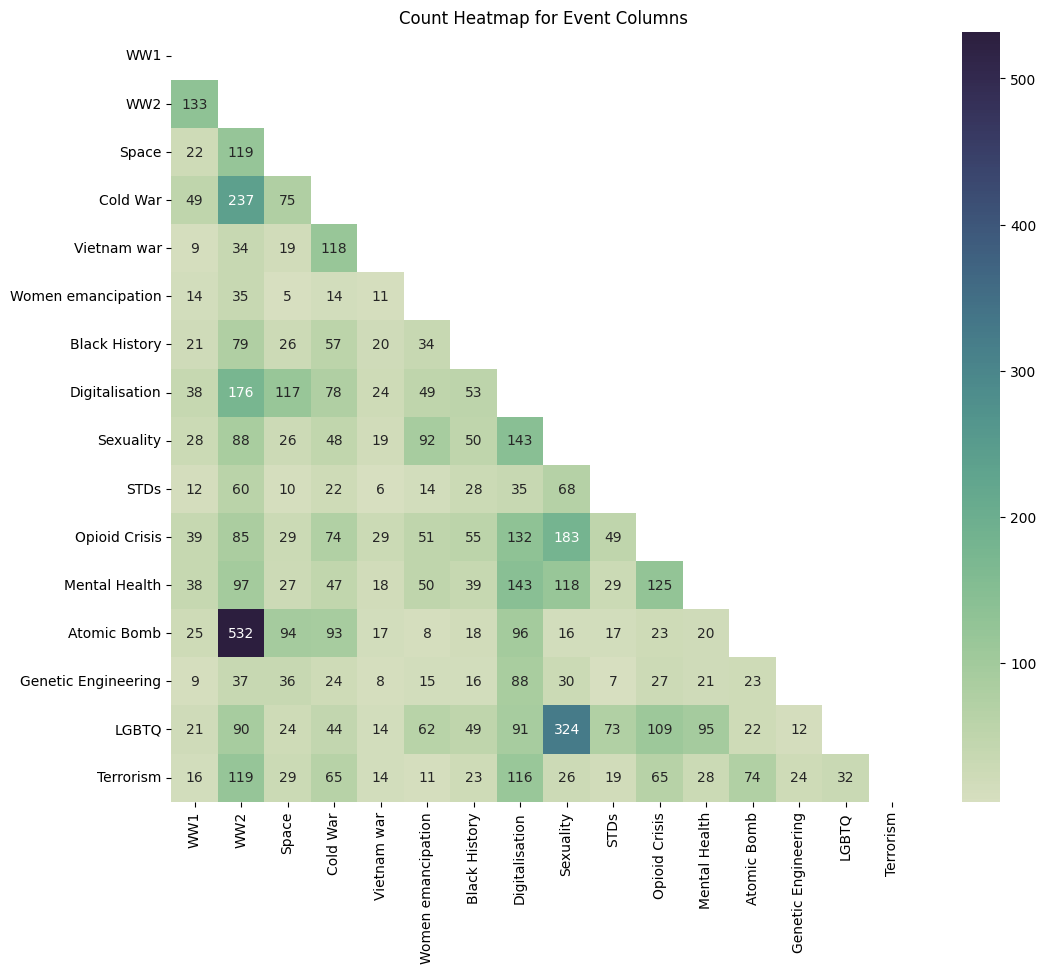

In [40]:
# Create a DataFrame with counts of occurrences of events

count_matrix = df[events].T.dot(df[events])


# Create a mask for the upper triangle to reduce computation time

mask = np.triu(np.ones_like(count_matrix, dtype=bool))


# Plot the heatmap

plt.figure(figsize=(12, 10))
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
sns.heatmap(count_matrix, annot=True, cmap=cmap, fmt="d", mask=mask)

plt.title("Count Heatmap for Event Columns")
plt.show()

>When looking at this heatmap, the most shared events among pairwise combinations of movies are:
>
>- WW2 & WW1
>- Atomic Bomb & WW2
>- Cold War & WW2
>- Sexuality & LGBTQ
>- Sexuality & Opioid Crisis.
>
> These are reasonable shared events per movie, and we can say that our dictionary method seems reasonable overall.
> 
> We see that some of the high numbers in the heatmap are not in the correlation matrix. This may be because here we only look at the number of shared movies while ignoring the other correlations, which shows other interesting interactions.


#### 3.3.3 Evaluation using a Test Set

##### 3.3.3.1 Test Set and Classification

> To further test the performance of our dictionary-based classification, we created a 'testing set' of movies for which we already know the corresponding event/movement. This data was obtained from websites listing movies by category, such as [imdb](https://www.imdb.com/). We then applied our dictionary-based classification methods to this test set and compared the results with the true events of the movies.
>
> Note: the Testset will consist of 10 specific movies per event

In [42]:
# Creating the test sets : dataframes of movies with known associated event or movement

# Test subset for WW1

ww1_test_set = pd.DataFrame({
    'id_wiki': [354122, 4592959, 1198629, 6361585, 5403512, 5501736, 7133888, 73368, 62097, 23255],
    'id_freebase': ['/m/01znj1', '/m/0cbl95', '/m/04gm93', '/m/0g2h97', '/m/0dk937', '/m/0dpq1q', '/m/0h5ys_', '/m/0jq1x', '/m/0gsx1', '/m/05sjq'],
    'name': ['Gallipoli', 'All Quiet on the Western Front', 'Aces High', 'The Red Baron', 'Flyboys', 'Darling Lili', 'The Lost Patrol', 'The Big Parade', 'Grand Illusion', 'Paths of Glory'],
    'date': ['1981', '1930-04-21', '1976', '2008-03-31', '2006-09-22', '1970-06-24', '1934-02-16', '1925', '1937', '1957']
})
ww1_test_set['true_event'] = 'WW1' 


# Test subset for WW2

ww2_test_set = pd.DataFrame({
    'id_wiki': [57585, 4492505, 8994, 182164, 633052, 14725310, 28269, 65834, 42159, 42856],
    'id_freebase': ['/m/0ft18', '/m/0c5d5j', '/m/02h22', '/m/018wsw', '/m/02yvct', '/m/0gy0l_', '/m/07024', '/m/0hfzr', '/m/0bl5c', '/m/0bs4r'],
    'name': ['Casablanca', 'Come and See', 'Das Boot', 'Grave of the Fireflies', 'Inglourious Basterds', 'Letters from Iwo Jima', 'Saving Private Ryan', "Schindler's List", 'The Best Years of Our Lives', 'The Bridge on the River Kwai'],
    'date': ['1942-11-26', '1985', '1981-09-17', '1988-04-16', '2009-05-20', '2006-12-09', '1998-07-24', '1993-11-30', '1946', '1957-10-02']
})
ww2_test_set['true_event'] = 'WW2' 


# Test subset for Space Race

space_exploration_test_set = pd.DataFrame({
    'id_wiki': [142417, 6446053, 113442, 1110047, 13887546, 11378430, 879000, 4338909, 3146408, 103325],
    'id_freebase': ['/m/011yd2', '/m/025twgf', '/m/0sxgv', '/m/046vs6', '/m/03cm7j_', '/m/02r9hx1', '/m/03l3hv', '/m/0bxy6l', '/m/08vf0c', '/m/0q23s'],
    'name': ['Apollo 13', 'Dr. No', 'The Right Stuff', 'October Sky', 'From the Earth to the Moon', 'The Mouse on the Moon', 'Destination Moon', 'Countdown', 'G.O.R.A.', 'Royal Space Force: The Wings of Honneamise'],
    'date': ['1995-06-22', '1962-10-05', '1983-10-21', '1999-02-19', '1958', '1963', '1950-06-27', '1968', '2004-11-12', '1987-03-14']
})
space_exploration_test_set['true_event'] = 'Space' 


# Test subset for Cold War

cold_war_test_set = pd.DataFrame({
    'id_wiki': [464883, 1129041, 37241569, 566713, 113442, 34130, 5454803, 2663129, 58147, 8695],
    'id_freebase': ['/m/02crgz', '/m/048scx', '/m/0n53wvj', '/m/02qrv7', '/m/0sxgv', '/m/08720', '/m/0dmn0x', '/m/07w8fz', '/m/0fy66', '/m/02dwj'],
    'name': ['Miracle', 'Thirteen Days', 'Cold War', 'The Living Daylights', 'The Right Stuff', 'WarGames', 'The Lives of Others', 'Good Night, and Good Luck.', 'The Manchurian Candidate', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb'],
    'date': ['2004-02-06', '2000-12-16', '2012-11-08', '1987', '1983-10-21', '1983-06-03', '2006-03-15', '2005-09-01', '1962-10-24', '1964-01-29']
})
cold_war_test_set['true_event'] = 'Cold War' 


# Test subset for Vietnam War

vietnam_war_test_set = pd.DataFrame({
    'id_wiki': [18951054, 11701, 1011468, 3859075, 168593, 2478590, 675947, 103011, 1546168, 113460],
    'id_freebase': ['/m/0jzw', '/m/0333t', '/m/03z106', '/m/0b3nrz', '/m/016kxf', '/m/07gv6d', '/m/0320br', '/m/0p_qr', '/m/0599rp', '/m/0sxmx'],
    'name': ['Apocalypse Now', 'Full Metal Jacket', 'We Were Soldiers', 'Rescue Dawn', 'Good Morning, Vietnam', 'Tigerland', 'Hamburger Hill', 'Coming Home', 'Heaven & Earth', 'Platoon'],
    'date': ['1979-05-10', '1987-06-17', '2002-02-25', '2006-09-09', '1987-12-23', '2000-10-06', '1987-08-28', '1978-02-15', '1993-12-13', '1986-12-19']
})
vietnam_war_test_set['true_event'] = 'Vietnam war' 


# Test subset for Women Emancipation

women_emancipation_test_set = pd.DataFrame({
    'id_wiki': [1164646, 390693, 25594421, 2148370, 74018, 5527808, 11347793, 176762, 444267, 249876],
    'id_freebase': ['/m/04cq1k', '/m/022npf', '/m/09rvcvl', '/m/06qbrw', '/m/0jsxn', '/m/0dq_ss', '/m/02r8hh_', '/m/017zss', '/m/0296vv', '/m/01l2b3'],
    'name': ['Iron Jawed Angels', 'Born in Flames', 'Made in Dagenham', 'North Country', 'His Girl Friday', 'The Joy Luck Club', 'Persepolis', 'Whale Rider', 'Legally Blonde', 'Bend It Like Beckham'],
    'date': ['2004-01-16', '1983', '2010-09-11', '2005-10-21', '1940-01-11', '1993-09-08', '2007-06-27', '2002-09-09', '2001-06-26', '2002-04-11']
})
women_emancipation_test_set['true_event'] = 'Women emancipation' 


# Test subset for Black History

black_history_test_set = pd.DataFrame({
    'id_wiki': [300972, 73428, 29454281, 225487, 2084045, 155997, 1073955, 19032190, 73428, 397574],
    'id_freebase': ['/m/01rwyq', '/m/0jqkh', '/m/0ds3t5x', '/m/01gvwd', '/m/06l2pj', '/m/014gcy', '/m/043ncp', '/m/09rsjpv', '/m/0jqkh', '/m/023gxx'],
    'name': ['Malcolm X', 'Do the Right Thing', 'The Help', 'Claudine', 'Crooklyn', 'Boyz N the Hood', 'Soul Food', 'Red Tails', 'Do the Right Thing', 'Remember the Titans'],
    'date': ['1992-11-18', '1989-05', '2011-08-10', '1974', '1994-05-13', '1991-07-02', '1997-09-26', '2012-01-20', '1989-05', '2000-09-23']
})
black_history_test_set['true_event'] = 'Black History' 


# Test subset for Digitalisation

digitalization_test_set = pd.DataFrame({
    'id_wiki': [23941708, 30007, 34344124, 3746, 672934, 142224, 4273140, 1368785, 306195, 49696],
    'id_freebase': ['/m/08ct6', '/m/07cz2', '/m/07gp9', '/m/017n9', '/m/031qr5', '/m/011xg5', '/m/0bth54', '/m/04x7w0', '/m/01sk1v', '/m/0d6b7'],
    'name': ['2001: A Space Odyssey', 'The Matrix', 'Terminator 2: Judgment Day', 'Blade Runner', 'The Lawnmower Man', 'A.I. Artificial Intelligence', 'Avatar', 'Freejack', 'The Net', 'Metropolis'],
    'date': ['1968-04-06', '1999-03-31', '1991-07-01', '1982-06-25', '1992-03-06', '2001-06-26', '2009-12-10', '1992-01-17', '1995-07-28', '1927-01-10']
})
digitalization_test_set['true_event'] = 'Digitalisation' 


# Test subset for Sexuality

sexuality_test_set = pd.DataFrame({
    'id_wiki': [4838538, 44122, 1988806, 226842, 615121, 2141418, 2457326, 1897341, 28075240, 195388],
    'id_freebase': ['/m/0cqbfc', '/m/0c0zq', '/m/06c753', '/m/01h1zp', '/m/02wtp6', '/m/06ptw1', '/m/07fg13', '/m/064lsn', '/m/0cmc26r', '/m/01brqv'],
    'name': ['Summer with Monika', 'American Beauty', 'Lolita', 'Ken Park', 'The Dreamers', 'Mysterious Skin', 'Palindromes', 'The Pianist', 'A Dangerous Method', 'Y tu mamá también'],
    'date': ['1953', '1999-09-08', '1997-09-27', '2002-08-31', '2003-09-01', '2004-09-03', '2005-01-21', '2002-05-24', '2011-09-02', '2001-06-08']
})
sexuality_test_set['true_event'] = 'Sexuality' 


# Test subset for STDs

stds_test_set = pd.DataFrame({
    'id_wiki': [615418, 6256985, 28194808, 2046284, 11517671, 23266463, 468353, 543162, 13699003, 1367539],
    'id_freebase': ['/m/02ww1t', '/m/0fz68f', '/m/0cnx21r', '/m/06hbq5', '/m/02rgktd', '/m/065_f26', '/m/02d49z', '/m/02nczh', '/m/03cffvv', '/m/04x4rr'],
    'name': ['Kids', 'Teenage Caveman', 'Black Venus', "She's Too Young", 'Damaged Lives', 'Girl, Positive', 'Thirteen', "Boys Don't Cry", 'And the Band Played On', 'Longtime Companion'],
    'date': ['1995-05', '2002', '2010-09', '2004-02-16', '1933', '2007-06-25', '2003-01-17', '1999-09-02', '1993-09-11', '1989-10']
})
stds_test_set['true_event'] = 'STDs' 


# Test subset for Opioid Crisis

opioid_crisis_test_set = pd.DataFrame({
    'id_wiki': [37599, 23830211, 3182907, 105434, 5842075, 1611072, 2470904, 1380618, 2244939, 6179073],
    'id_freebase': ['/m/09cr8', '/m/07k2mq', '/m/08xnxg', '/m/0qf2t', '/m/0f8j13', '/m/05gjj1', '/m/07gb81', '/m/04y2j6', '/m/06yv1n', '/m/0fvcx9'],
    'name': ['Traffic', 'Requiem for a Dream', 'The Basketball Diaries', 'Trainspotting', 'Fear and Loathing in Las Vegas', 'A Scanner Darkly', '28 Days', 'Permanent Midnight', 'Clean and Sober', 'Less Than Zero'],
    'date': ['2001-01-05', '2000-10-27', '1995-04-21', '1996-02-23', '1998-05-15', '2006-07-07', '2000-02-08', '1998-09-16', '1988', '1987-11-06']
})
opioid_crisis_test_set['true_event'] = 'Opioid Crisis' 


# Test subset for Mental Health

mental_health_test_set = pd.DataFrame({
    'id_wiki': [54160, 33502433, 3383952, 7047921, 3569822, 106335, 26971354, 12685170, 9114950, 24480838],
    'id_freebase': ['/m/0f4vx', '/m/0h95927', '/m/098s2w', '/m/0h1x5f', '/m/09m6kg', '/m/0qm98', '/m/0fpkhkz', '/m/02x0fs9', '/m/027y5ys', '/m/09k56b7'],
    'name': ['Leaving Las Vegas', 'The Silver Linings Playbook', 'Girl, Interrupted', 'Little Miss Sunshine', 'A Beautiful Mind', 'Ordinary People', 'Melancholia', 'Lars and the Real Girl', 'Fight Club - Members Only', 'Black Swan'],
    'date': ['1995-09-15', '2012-11-21', '1999-12-08', '2006-01-20', '2001-12-13', '1980-09-19', '2011-05-18', '2007-09-10', '2006-02-17', '2010-09-01']
})
mental_health_test_set['true_event'] = 'Mental Health' 


# Test subset for Atomic Bomb

atomic_bomb_test_set = pd.DataFrame({
    'id_wiki': [8695, 123464, 993867, 936429, 242542, 37068, 8863891, 31607, 18735140, 31629],
    'id_freebase': ['/m/02dwj', '/m/0x2j1', '/m/03xj57', '/m/03rk23', '/m/01k5_t', '/m/097r7', '/m/027mh15', '/m/07s5y', '/m/04gppzp', '/m/07sc1'],
    'name': ['Dr. Strangelove, or: How I Learned to Stop Worrying and Love the Bomb', 'Fail-Safe', "By Dawn's Early Light", 'Miracle Mile', 'Testament', 'The War Game', 'When the Wind Blows', 'The Day After', 'Barefoot Gen', 'Threads'],
    'date': ['1964-01-29', '1964-10-07', '1990-05-19', '1988-09-11', '1932', '1965', '1986-10', '1983-11-20', '1983', '1984']
})
atomic_bomb_test_set['true_event'] = 'Atomic Bomb' 


# Test subset for Genetic Engineering

genetic_engineering_test_set = pd.DataFrame({
    'id_wiki': [30340901, 146947, 42886, 3746, 27098, 31893898, 50957, 14899108, 456601, 1168522],
    'id_freebase': ['/m/0gwm_wy', '/m/012s1d', '/m/0bscw', '/m/017n9', '/m/06r2_', '/m/0gvrtf4', '/m/0dfw0', '/m/02qr2tx', '/m/02bqxb', '/m/04d0ng'],
    'name': ['Elysium', 'Spider-Man', 'Gattaca', 'Blade Runner', 'Star Trek II: The Wrath of Khan', 'The Deep Blue Sea', 'Star Wars Episode II: Attack of the Clones', 'Splice', 'The Fly', 'Mimic'],
    'date': ['2013-03-01', '2002-05-03', '1997-09-07', '1982-06-25', '1982-06-04', '2011-09-11', '2002-05-16', '2009-10-06', '1986-08-15', '1997-08-22']
})
genetic_engineering_test_set['true_event'] = 'Genetic Engineering' 


# Test subset for LGBTQIA+

lgbtq_test_set = pd.DataFrame({
    'id_wiki': [3146002, 1367539, 61664, 1856185, 24207129, 15782460, 4752795, 33025020, 455013, 468293],
    'id_freebase': ['/m/08vd2q', '/m/04x4rr', '/m/0gpx6', '/m/061dj0', '/m/07l50_1', '/m/03ntf1h', '/m/0clh4y', '/m/0fpmrmq', '/m/02bk82', '/m/02d41336193'],
    'name': ['Sunday Bloody Sunday', 'Longtime Companion', 'All About My Mother', 'Jeffrey', 'A Single Man', 'Hedwig and the Angry Inch', 'Before Night Falls', 'Pariah', 'The Boys in the Band', 'Philadelphia'],
    'date': ['1971', '1989-10', '1999-04-08', '1995', '2009-09-11', '2001-01-19', '2001-01-26', '2011-01-20', '1970-03-17', '1993']
})
lgbtq_test_set['true_event'] = 'LGBTQ' 


# Test subset for Terrorism

terrorism_test_set = pd.DataFrame({
    'id_wiki': [1891886, 34953010, 15497901, 185058, 2311219, 16733548, 33028800, 3634311, 106328, 2174599],
    'id_freebase': ['/m/0645k5', '/m/0j43swk', '/m/03mc6yp', '/m/0198lt', '/m/072x7s', '/m/0404j37', '/m/0h03fhx', '/m/09r94m', '/m/0qm8b', '/m/06sfk6'],
    'name': ['V for Vendetta', 'Zero Dark Thirty', 'The Baader Meinhof Complex', '9/11', 'Munich', 'The Hurt Locker', 'Argo', 'United 93', 'Black Hawk Down', 'The Siege'],
    'date': ['2006-02-13', '2012-12-19', '2008-09-25', '2002-03-10', '2005-12-23', '2008-09-04', '2012-08-31', '2006-04-28', '2001-12-18', '1998-11-06']
})
terrorism_test_set['true_event'] = 'Terrorism'

In [43]:
# Concatenating all these test sets into one big dataframe

movies_test_set = pd.concat([ww1_test_set, ww2_test_set, space_exploration_test_set, cold_war_test_set, vietnam_war_test_set, women_emancipation_test_set, black_history_test_set, digitalization_test_set, sexuality_test_set, stds_test_set, opioid_crisis_test_set, mental_health_test_set, atomic_bomb_test_set, genetic_engineering_test_set, lgbtq_test_set, terrorism_test_set], ignore_index=True)

movie_plots = plot_summaries.copy()


# Merge movies_test_set and plot_summaries datasets

merged_test_set_plots = pd.merge(movies_test_set, movie_plots, how = 'left', left_on = 'id_wiki', right_on = 'id_wiki_movie')


# Match each movie to an event using our dictionaries

movies_test_set_events = add_event_columns(merged_test_set_plots, dictionaries_df).copy()
movies_test_set_events = create_events_belongs_to_column(movies_test_set_events, events).copy()

##### 3.3.3.2 Percentage of Correct Matching
>By comparing the dictionnary-mapped events and the given event for all movies we can compute the percentage of correct matching for each event or movement.

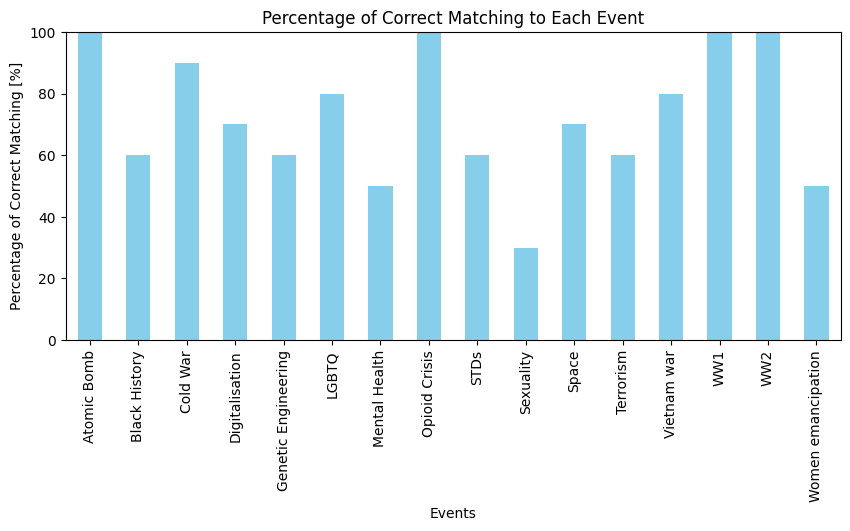

In [44]:
# Check matching 

movies_test_set_events['correct_matching'] = movies_test_set_events.apply(check_matching, axis=1)


# Calculate the percentage of correct matching for each event/movement

movies_test_set_events_grouped = movies_test_set_events.groupby('true_event')['correct_matching'].mean() * 100


# Plot correct matching

plt.figure(figsize=(10, 4))
movies_test_set_events_grouped.plot(kind='bar', color='skyblue')
plt.title('Percentage of Correct Matching to Each Event')
plt.xlabel('Events')
plt.ylabel('Percentage of Correct Matching [%]')
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.show()

>From this plot it seems like some of our dictionaries, such as the one for Sexuality for example, are very unaccurate. If this is the case we might want to review those specific dictionaries, or exclude the corresponding events from the analysis completely for Milestone 3.
>
>However this plot only shows True Positive values of our prediction model, that is, it takes into account only the number of movies that should have been and were indeed matched to the corresponding event and not the ones that were wrongly matched or that sould not have been matched at all. In order to evaluate the entirety of our model, and the real quality of our dictionaries, we have to take into account the number of true positives, true negatives, false positives and false negatives.

##### 3.3.3.3 Performance Statistics of the Classification 

>Using the event-matched test set, we are able to compute the number of true positives, true negatives, false positives and false negatives in our prediction. This result is shown in a confusion matrix. From this we can then compute the performance statistics of our dictionary-based matching : accuracy, precision, recall, f1 score and specificity. 

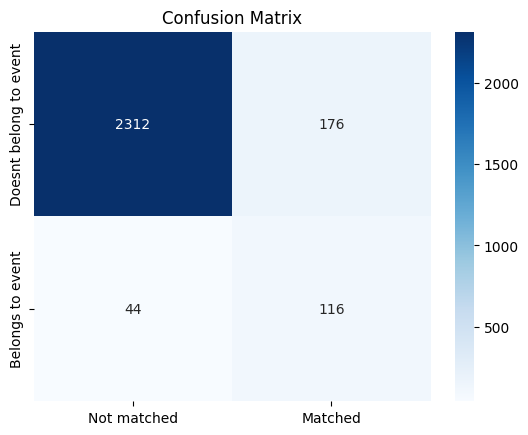

In [51]:
# Compute True Positives (TP), True Negatives (TN), False Positives (FP) and False Negative (FN) from the test sets

TP = 0
FN = 0
FP = 0
TN = 0

for index, movie in movies_test_set_events.iterrows() : 
    if (movie['correct_matching'] == True) :
        TP += 1
        FP += len(movie['events_belongs_to']) - 1
        TN += len(events) - len(movie['events_belongs_to']) 
    else :
        FN += 1
        TN += len(events) - len(movie['events_belongs_to']) + 1
        FP += len(movie['events_belongs_to'])

# Construct confusion matrix

conf_matrix = confusion_matrix(y_true=[1] * (TP + FN) + [0] * (TN + FP),
                               y_pred=[1] * TP + [0] * FN + [1] * FP + [0] * TN)


# Plot confusion matrix as a heatmap

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not matched', 'Matched'],
            yticklabels=['Doesnt belong to event', 'Belongs to event'])

plt.title('Confusion Matrix')
plt.show()

>From this confusion matrix two things stand out :
>- there is a very large number of true negatives (2312), that is the number of movies that were correctly not matched to an event they don't correspond to.
>- there is a very small number of false negatives (44), that is movies that were not matched to any event when they should have been matched.
>
>However these numbers are less extreme for true positives (116) and false positives (176), which is not a result we want. This indicates that among movies that were matched to an event, about half does not actually belong to that event. 
>
>These are good results, since ideally we would want the number of true positives and true negatives to be high and the number of false positives and false negatives to be low.
>
>The goal for milestone 3 is to optimize the dictionaries and the matching process in order to have more true positives and less false positives.


In [53]:
# Performance metrics

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

print('Statistics of our dictionary-based prediction model:')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1)
print('Specificity: ', specificity)

Statistics of our dictionary-based prediction model:
Accuracy:  0.9169184290030211
Precision:  0.3972602739726027
Recall:  0.725
F1 score:  0.5132743362831859
Specificity:  0.9292604501607717


> Now, with these performance scores on the test set, we can further understand the validity of our method to match a movie to a specific event. The accuracy, specificity, and recall are quite high, indicating robust performance. However, the lower precision and F1 score suggest that, despite a good rate of true negatives, we lack precision. We have more False Positives than True Positives, which doesn't yield a good ratio.
>
> To address this issue, we might consider further testing of our dictionaries for milestone 3. 
>One way to optimize this would be to identify which event-dictionaries are too sensitive. This could be done by examining these different measures while excluding one 'event' dictionary at a time and then change the threshold of minimum matching words accordingly.

## 4 Diving into the Analysis of Events

> The tool we created to link movies to specific historical/movement events allows us to more easily examine the impacts of such events on society.

#### 4.1 Number of Movies per Event Over the Years

> In this section, we plot the count of movies for each event per year. This not only shows which events are more popular and 'more interesting' to society but also serves as additional testing for our dictionary-based event classification. For example, we don't expect movies about WW2 to occur before 1939.

In [ ]:
plot_events_over_years(movies_events, events, figures_per_row = 4)

> We can observe that the representation of all events in cinema shows an increase throughout the century. However, this can be linked to the fact that the movie industry also experienced significant growth. In section 2, we created a similar plot where indeed the number of movies (all combined) has increased significantly over the years.

> Additionally, we can check the timeline for each event's movie releases, and they seem coherent overall. We can see that more WW2 movies were not released before 1940, which is reassuring. The same is true for the production of Vietnam War movies, which started to increase around 1970.

ANOVA test to compare the different events regarding the percentage of movies produced each year:

In [ ]:
event_percentage = {event: get_year_percentage(movies_events, event) for event in events}


# Extract values from the dictionary for each event

samples_unified = list(event_percentage.values())


# Test ANOVA

result_ANOVA = f_oneway(*samples_unified)


# Print results

print("F-statistic:", result_ANOVA.statistic)
print("P-value:", result_ANOVA.pvalue)

> The p-value is very small, indicating significant evidence to reject the null hypothesis. This suggests that at least one event's mean proportion over the years is different from the others

#### 4.2 Number of countries where a event was put into a movie

>One measure of the impact a historical event had is to see how international this event was. By looking at the number of countries that made a movie about a specific event we plan to see how impactful this specific event was.

In [ ]:
# Count the number of unique countries in the specified column for each DataFrame

dataframes_events = []
for event in events:
    dataframes_events.append(movie_affected_to_event(movies_events_df, event))
unique_country_counts = [df['country'].apply(tuple).nunique() for df in dataframes_events]    

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab20.colors[:len(events)]   # Define a custom color palette
bar_width = 0.8

bar_positions = np.arange(len(events))
ax.bar(bar_positions, unique_country_counts, bar_width, color=colors, align='center')
ax.set_xticks(bar_positions)
ax.set_xticklabels(events, rotation=45, ha='right')
ax.set_ylabel('Number of Unique Countries')
ax.set_title('Number of Countries who made a movie for an event')

plt.show()

In [ ]:
# Calculate the coefficient of variation
cv = np.std(unique_country_counts) / np.mean(unique_country_counts)


# Print the coefficient of variation

print(f'Coefficient of Variation: {cv:.3f}')

# You can also print other measures such as standard deviation

print(f'Standard Deviation: {np.std(unique_country_counts):.3f}')

We can see that the coefficient of variation and the standard deviation are high (CoV higher than 0.3). This could indicate that the number of countries that made a movie about a specific event varies to a certain degree. In order to take any conclusions we should explore the distribution of the data further in P3.

#### 4.3 Box office revenue

Another measure of the impact of an event could be the box office revenue which gives us a quantifiable measure of how many people went to watch a movie talking about a specific event.

In [ ]:
# Represent the different box office revenues in a scatterplot

all_averages = []
all_conf_intervals = []

for i, element in enumerate(events):
    element_events = movie_affected_to_event(movies_events_df, element)
    element_revenue = element_events['box_office'].copy()
    element_revenue_cleaned = element_revenue.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_revenue_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_revenue_cleaned)-1, loc=avg, scale=stats.sem(element_revenue_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 

plt.scatter(range(len(events)), all_averages, marker='o', color='red', s=20, label='Mean')


# Plotting vertical lines for confidence intervals

plt.vlines(x=range(len(events)), ymin=lower_bound, ymax=upper_bound, color='blue', alpha=0.7, label='95% CI')


# Set labels and title and x-axis ticks & labels

plt.xlabel('Events')
plt.ylabel('Average Revenue')
plt.title('Average revenue for movies from different events')
plt.xticks(range(len(events)), events, rotation='vertical')

plt.legend()
plt.show()


>We can see that the confidence do not overlap. However in order to analyse this property we have to consider that 50 % of the column are nans. For P3 it would be good to find an additional dataset that can even further enrich this column. We also have not taken inflation into account yet, this would be an interesting aspect to consider for further analysis.

#### 4.4 Rating

> We imported two external datasets that add reviews to the movies of their audience. We will have to evaluate which one we will use for analysis and to do that we analyze the percentage of NaN's contained in both dataframes for the 'rating'. 

> In the first dataset that we imported ('movies_events_reviews_df'), the maximal review a movie can obtain is a 10, and the minimal is a 0. Since we already merged the reviews with only the movies that belong to an event, we will now calculate the percentage of NaN's contained in their reviews. 

In [ ]:
MOVIES_WITH_EVENTS_AND_REVIEWS = "movies_with_events_and_reviews_unique.csv"
movies_events_reviews_df = pd.read_csv(MOVIES_WITH_EVENTS_AND_REVIEWS)

In [ ]:
only_rating_column = movies_events_reviews_df['rating'].copy()
only_rating_column_df = pd.DataFrame(only_rating_column)

compute_nan_count_and_percentage(only_rating_column_df)

> Unfortunately, we see that this means that only approximately 10% of movies have a rating. We will therefore continue to analyse the percentage of NaN's of ratings in the 'imdb_df' dataset.

In [ ]:
# Process and merge the imdb ratings with the mvoie events

imdb_ratings_popularity_df = imdb_df.copy()
imdb_ratings_popularity_df.drop(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'original_title', 'title', 'original_language', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'video'], axis=1, inplace=True)


# Merging the dataframe containing popularity and vote_average with the dataframe containing the freebase id translations

imdb_ratings_popularity_freebaseid_df = pd.merge(imdb_ratings_popularity_df, id_translations, on='imdb_id', how='left')


# Merging the previous dataframe with the dataframe of all movies contained in at least one event (movies_events_df)

movies_events_to_merge_df = movies_events_df.copy()
movies_events_to_merge_df.drop(['id_wiki', 'box_office', 'runtime', 'lang', 'country', 'genre', 'id_wiki_movie', 'summary', 'world_region', 'new_genre'], axis=1, inplace=True)
imdb_ratings_popularity_events_df = pd.merge(movies_events_to_merge_df, imdb_ratings_popularity_freebaseid_df, on='id_freebase', how='left')

In [ ]:
only_rating_column_imdb = imdb_ratings_popularity_events_df['vote_average'].copy()
only_rating_column_imdb_df = pd.DataFrame(only_rating_column_imdb)

compute_nan_count_and_percentage(only_rating_column_imdb_df)

> From this we can conclude that we rather use the imdb review dataset addition than the dataset that we use for the emotional analysis. Of course, approximately 50% of NaN's still have to be considered. We have decided that 50% is sufficient to represent the other 50% of movies of the corresponding events, to show that our principle works. However, for milestone 3, we will have to evaluate whether to import a more complete dataset. 

In [ ]:
# Represent the different voting averages in a scatterplot

all_averages = []
all_conf_intervals = []

for i, element in enumerate(events):
    element_events = movie_affected_to_event(imdb_ratings_popularity_events_df, element)
    element_ratings = element_events['vote_average'].copy()
    element_ratings_cleaned = element_ratings.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_ratings_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_ratings_cleaned)-1, loc=avg, scale=stats.sem(element_ratings_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 

plt.scatter(range(len(events)), all_averages, marker='o', color='red', s=20, label='Mean')


# Plotting vertical lines for confidence intervals

plt.vlines(x=range(len(events)), ymin=lower_bound, ymax=upper_bound, color='blue', alpha=0.7, label='95% CI')


# Set labels and title and x-axis ticks & labels

plt.xlabel('Events')
plt.ylabel('Voting-Average')
plt.title('Voting-Average for movies from different events')
plt.xticks(range(len(events)), events, rotation='vertical')

plt.legend()
plt.show()

> When observing the above plot it is important to remark that the y-axis is only between the rating of 5.7 and 6.2. This shows us that the votings all lie relatively close next to eachother. However, it is also important to note that there do exist significant differences between voting-averages from the events where the confidance intervals do not overlap. This means that we can use the differences in voting-average as a utensil to find the most impactful event.

#### 4.5 Number of Rating Votes

> A further way to analyse the impact of a movie is to look at how many people rated the movie (meaning that they watched it and that they probably felt strongly enough about it to fill out a review). This is why we will evaluate the average number of rating votes for each event. 

> As a first step we have to evaluate how many NaN's are contained for this column. 

In [ ]:
only_vote_count_column_imdb = imdb_ratings_popularity_events_df['vote_count'].copy()
only_vote_count_column_imdb_df = pd.DataFrame(only_vote_count_column_imdb)

compute_nan_count_and_percentage(only_vote_count_column_imdb_df)

> As we can see, we have the same amount of NaN's as in the Votes column, which makes sense. Therefore, with the same justification as before we reason to analyse this element. 

In [ ]:
# Represent the different voting count averages in a scatterplot

all_averages = []
all_conf_intervals = []

for i, element in enumerate(events):
    element_events = movie_affected_to_event(imdb_ratings_popularity_events_df, element)
    element_ratings = element_events['vote_count'].copy()
    element_ratings_cleaned = element_ratings.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_ratings_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_ratings_cleaned)-1, loc=avg, scale=stats.sem(element_ratings_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 

plt.scatter(range(len(events)), all_averages, marker='o', color='red', s=20, label='Mean')


# Plotting vertical lines for confidence intervals

plt.vlines(x=range(len(events)), ymin=lower_bound, ymax=upper_bound, color='blue', alpha=0.7, label='95% CI')


# Set labels and title and x-axis ticks & labels

plt.xlabel('Events')
plt.ylabel('Voting-Count')
plt.title('Voting-Count for movies from different events')
plt.xticks(range(len(events)), events, rotation='vertical')

plt.legend()
plt.show()

> When observing the plot above, we are able to see that significant differences between voting-count averages from the events exist, since the confidance intervals do not overlap. This means that we can use the differences in voting-count average as a utensil to find the most impactful event.

#### 4.6 Popularity

> A further way to analyse the impact of a movie is to look at how 'popular' a movie is. For this we use the column 'popularity' that we imported with our imdb database and analyse the average of popularity for the different events. 

> As a first step we have to evaluate how many NaN's are contained for this column. 

In [ ]:
only_popularity_column_imdb = imdb_ratings_popularity_events_df['popularity'].copy()
only_popularity_column_imdb_df = pd.DataFrame(only_popularity_column_imdb)

compute_nan_count_and_percentage(only_popularity_column_imdb_df)

> As we can see, we have the same amount of NaN's as in the Votes column. Therefore, with the same justification as before we reason to analyse this element. 

In [ ]:
# Represent the different popularity averages in a scatterplot

all_averages = []
all_conf_intervals = []

imdb_ratings_popularity_events_df['popularity'] = pd.to_numeric(imdb_ratings_popularity_events_df['popularity'], errors='coerce')

for i, element in enumerate(events):
    element_events = movie_affected_to_event(imdb_ratings_popularity_events_df, element)
    element_ratings = element_events['popularity'].copy()
    element_ratings_cleaned = element_ratings.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_ratings_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_ratings_cleaned)-1, loc=avg, scale=stats.sem(element_ratings_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 

plt.scatter(range(len(events)), all_averages, marker='o', color='red', s=20, label='Mean')


# Plotting vertical lines for confidence intervals

plt.vlines(x=range(len(events)), ymin=lower_bound, ymax=upper_bound, color='blue', alpha=0.7, label='95% CI')


# Set labels and title and x-axis ticks & labels

plt.xlabel('Events')
plt.ylabel('Popularity')
plt.title('Popularity for movies from different events')
plt.xticks(range(len(events)), events, rotation='vertical')

plt.legend()
plt.show()

> When observing the plot above, we are able to see that significant differences between popularity averages from the events exist, since the confidance intervals do not overlap. This means that we can use the differences in popularity average as a utensil to find the most impactful event.

#### 4.7 Review - Sentiment analysis

>To analyse the feeling that the public conveys through its reviews, we thought of comparing the words they use in their texts to words that are generally associated with positive or negative emotions. To perform this comparison, we used two words' lists from *Patrick O.Perry*, a lead data sceintist at Oscar Health.

In [ ]:
# Import the positive words' list and store it in a DataFrame

POSITIVE_URL = "https://ptrckprry.com/course/ssd/data/positive-words.txt"

positive_words_df = pd.read_csv(POSITIVE_URL, header = 32, names = ['words'], sep = ' ', encoding = 'latin1')

In [ ]:
# Import the negative words' list and store it in a DataFrame

NEGATIVE_URL = "https://ptrckprry.com/course/ssd/data/negative-words.txt"

negative_words_df = pd.read_csv(NEGATIVE_URL, header = 32, names = ['words'], sep = ' ', encoding = 'latin1')

##### 4.7.1 Reviews Preprocessing

In [ ]:
movies_events_reviews_df = movies_events_reviews.copy()
compute_nan_count_and_percentage(movies_events_reviews_df)

>As one can notice, there is a high proportion of NaN values in reviews' data. However, we decided to pursue the emotions' assessment in reviews since we have around 4000 films with reviews.

In [ ]:
# Dropping NaN values respectively in the review_summary and review_detail columns

movies_events_reviews_summary_nona_df = movies_events_reviews_df.dropna(subset = ['review_summary'], axis = 0)
movies_events_reviews_detail_nona_df = movies_events_reviews_df.dropna(subset = ['review_detail'], axis = 0)


# Resetting the index to a default one

movies_events_reviews_summary_nona_df.reset_index(inplace = True)
movies_events_reviews_summary_nona_df = movies_events_reviews_summary_nona_df.drop(['index'], axis = 1)

movies_events_reviews_detail_nona_df.reset_index(inplace = True)
movies_events_reviews_detail_nona_df = movies_events_reviews_detail_nona_df.drop(['index'], axis = 1)

>Before further investigating the reviews' details or summaries, we want to ensure that every movie which has a review summary also has detailed review. This allows us to guarantee that we did not ignore reviews' summaries by dropping NaN values of detailed reviews and vice-versa.

In [ ]:
# Test to see if some movies which have reviews' summaries don't have a detailed review

for i in range(movies_events_reviews_summary_nona_df.shape[0]):
    if movies_events_reviews_summary_nona_df.iloc[i]['review_detail'] == 'NaN':
        print("There is a movie for which we have a review summary but not a review detail.")
        
print("First test finished.")


# Test to see if some movies which have detailed reviews don't have a reviews' summaries

for i in range(movies_events_reviews_detail_nona_df.shape[0]):
    if movies_events_reviews_detail_nona_df.iloc[i]['review_summary'] == 'NaN':
        print("There is a movie for which we have a review detail but not a review summary.")
        
print("Second test finished.")

> Our tests successfully demonstrated that every movie in our processed DataFrame having a review summary has a detailed review and vice versa. Thus, from now on, we will only work on a single dataframe to centralize all our data.
>
>Let's now investigate the outliers' characteristics of reviews.

In [ ]:
# Testing for outliers contained in the "review_summary" column

outliers_review_summary = [summary for summary in movies_events_reviews_summary_nona_df['review_summary'] if type(summary) != str]
outliers_review_summary = list(set(outliers_review_summary))
print(outliers_review_summary)


# Testing for outliers contained in the "review_detail" column

outliers_review_summary = [detail for detail in movies_events_reviews_detail_nona_df['review_detail'] if type(detail) != str]
outliers_review_summary = list(set(outliers_review_summary))
print(outliers_review_summary)

>Important observations of the columns 'review_summary' and 'review_detail':
>
>* (NaNs values were already covered above)
>* Apart from Nan's there are no non-string values

##### 4.7.2 Emotions' ratios analysis

>To quantify the emotion transmitted by the public through its reviews, we decided to compute common words' ratios between the reviews' text itself and our positive or negative words' lists. These ratios can give us an idea of the amount of positivity and negativity present in reviews.

In [ ]:
movies_events_reviews_emotions_df = movies_events_reviews_summary_nona_df.copy()


# Adding 4 columns to the dataframe containing reviews: 
# 2 columns for positive/negative ratios computed using detailed reviews
# 2 columns for positive/negative ratios computed using reviews' summaries

movies_events_reviews_emotions_df = add_common_words_ratio(movies_events_reviews_emotions_df, 'review_detail', list(positive_words_df['words']), list(negative_words_df['words']))
movies_events_reviews_emotions_df = add_common_words_ratio(movies_events_reviews_emotions_df, 'review_summary', list(positive_words_df['words']), list(negative_words_df['words']))

>To simplify our code, analysis and visualizations, we decided to analyse the emotion transmitted by the reviewer either only in detailed reviews or in reviews summaries. To take a rigorous decision, we thought of performing two Principal Component Analysis (PCA). In fact, this technique is often used to reduce data dimensions but here we decided to apply it in a different context. Both times, we considered detailed reviews or reviews' summaries as target and corresponding positive and negative emotions' ratios as features. Thus, it allows us to show the amount of variance present in the data explained by the two features for each target and see which column allows us to observe the most differences between positive and negative emotions. 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharex=True, sharey=True)


# Defining the target for both PCAs

pca_target_df = movies_events_reviews_emotions_df[['movie']].sample(20)


# Defining features for both PCAs

detail_pca_data_df = movies_events_reviews_emotions_df[['positive_emotion_ratio_review_detail', 'negative_emotion_ratio_review_detail']]
summary_pca_data_df = movies_events_reviews_emotions_df[['positive_emotion_ratio_review_summary', 'negative_emotion_ratio_review_summary']]


# Plotting the PCAs

pca_plot(detail_pca_data_df, pca_target_df, axs[0])
pca_plot(summary_pca_data_df, pca_target_df, axs[1])

axs[0].set_title("PCA when considering detailed reviews as targets")
axs[1].set_title("PCA when considering reviews' summaries as targets")

plt.show()

>As we can observe on those two 2-dimensional PCA plots, the movies sampled are way more packed together and near the origin when we take the detailed reviews emotion ratios (both positive and negative) as features than when we are considering the reviews' summaries emotion ratios (also positive and negative).
>
>This means that a larger proportion of the emotions' ratios data is explained by reviews' summaries compared to detailed reviews. Indeed, as detailed reviews often contain more words, emotions
>
>Thus, from now on, we will only analyse positive and negative emotion ratios computed from reviews' summaries to simplify our analysis and avoid an overload of graphs and conclusions.

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# Defining the list of events

events = ['WW1', 'WW2', 'Cold War', 'Vietnam war', 'Women emancipation', 'Black History', 'Digitalisation', 'Sexuality', 'STDs', 'Opioid Crisis', 'Mental Health', 'Atomic Bomb', 'Genetic Engineering', 'LGBTQ', 'Terrorism']


# Plotting scatter plots of positive and negative emotion ratio per event

scatter_plot_according_events(movies_events_reviews_emotions_df, 'date', 'positive_emotion_ratio_review_summary', axs, events, 'Positive emotion ratio') 
scatter_plot_according_events(movies_events_reviews_emotions_df, 'date', 'negative_emotion_ratio_review_summary', axs, events, 'Negative emotion ratio') 


# Delete the last subplot (which is empty)

fig.delaxes(axs[3][3])


plt.tight_layout()
plt.show()

> ANALYSIS TO DO

In [ ]:
#maybe add code to 3.1!!
regions = {'europe_countries': ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime'],
'middle_east_countries': ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan'],
'asia_countries': ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma'],
'africa_countries': ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau'],
'south_central_america_countries': ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba'],
'other_countries': ['United States of America', 'Canada', 'Australia', 'New Zealand'],
'outlier_countries': [ 'German Language', 'Malayalam Language'] }


# Create a new column 'world_region' in the DataFrame
movies_dataframe['world_region'] = movies_dataframe['country'].apply(find_region, regions = regions)

movies_dataframe.head()

In [ ]:
# Group by 'date' and 'region' and calculate the mean number of languages spoken in the 'lang' column for each year and region
lang_per_year_region = movies_dataframe.groupby(['date', 'world_region'])[['lang']].apply(lambda x: pd.Series({'mean': np.mean(x['lang'].apply(len)), 'variance': np.var(x['lang'].apply(len))}))

# Reset the index to make 'world_region' a regular column
lang_per_year_region = lang_per_year_region.reset_index()

# Pivot the DataFrame for plotting
lang_per_year_region_pivot = lang_per_year_region.pivot(index='date', columns='world_region', values=['mean', 'variance'])

# Remove 'outlier_countries' from the regions list
regions = [region for region in lang_per_year_region_pivot.columns.get_level_values(1).unique() if region != 'outlier_countries']

#Plot in subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axs array for easy iteration
axs_flat = axs.flatten()

# Plot mean values
for i, region in enumerate(regions):
        region_data_mean = lang_per_year_region_pivot[('mean', region)]
        region_data_variance = lang_per_year_region_pivot[('variance', region)]

        axs_flat[i].plot(region_data_mean, 'o', label=f'{region} - Mean')
        axs_flat[i].fill_between(region_data_mean.index, region_data_mean - np.sqrt(region_data_variance), region_data_mean + np.sqrt(region_data_variance), alpha=0.3)

         # Add title and legend to each subplot
        axs_flat[i].set_title(region)
            

# Adjust layout
plt.tight_layout()
plt.show()


We can see that there we do not have enough movies for each region to be able to consistently analyze the number of languages spoken in the movies made in those regions. The closer we come to today the more movies we get and therefore the more dots(means) and also more variance. It is quite interesting to see that there was a drop around 1930 in Europe and the US. We might be able to analyze this to see if we can link it to one historical event. However, we would need to do further analyses to see whether this drop was maybe linked to the number of movies and so on.

5.4) plot percentage of women in movies over time in different regions. How does this plot change when looking at percentage of female main characters?

In [ ]:
# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_gender_df = characters[['id_wiki_movie', 'actor_gender']].copy()


# Number of characters per movie

characters_per_movie = characters_gender_df.value_counts(subset = ['id_wiki_movie'])
characters_per_movie.name = 'characters_per_movie'


# Number of characters per movie for each genre

women_per_movie = characters_gender_df.value_counts(subset = ['id_wiki_movie', 'actor_gender'])


# Number of female characters per movie (set number of male characters to 0 and then sum characters from both genders)

women_per_movie = women_per_movie.to_frame().reset_index()
women_per_movie.loc[women_per_movie['actor_gender'] != 'F', 'count'] = 0
women_per_movie = women_per_movie.drop(['actor_gender'], axis = 1)
women_per_movie = women_per_movie.groupby('id_wiki_movie')['count'].sum()
women_per_movie.name = 'women_per_movie'


# Merge number of characters and number of female characters per movie into one dataframe : character_stats_per_movie

character_stats_per_movie = characters_per_movie.to_frame().merge(women_per_movie, how = 'left', on = 'id_wiki_movie')


# Calculate proportion of female characters per movie

character_stats_per_movie['proportion_women'] = character_stats_per_movie['women_per_movie']/character_stats_per_movie['characters_per_movie']
character_stats_per_movie.index.names = ['id_wiki']


# Merge proportion of female characters with movies dataframe
# Allow to have information about time and places related to proportion of female characters

character_stats_movies = character_stats_per_movie.merge(movies_df, how = 'left', on = 'id_wiki')
character_stats_movies = character_stats_movies[['proportion_women', 'date', 'country']]

In [ ]:
# Average proportion of female characters in movies per year globally

proportion_women_per_year = character_stats_movies.groupby('date')['proportion_women'].mean()


# Plotting the average proportion of female characters in movies per year

plt.figure(figsize = (8, 4))
plt.bar(proportion_women_per_year.index, proportion_women_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average proportion of female characters')
plt.title('Average proportion of female characters in movies over the years globally')
plt.grid(True)
plt.show()

In [ ]:
# Plot average proportion of female characters in movies per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average proportion of female characters in movies per year for different regions', fontsize = 20)


# Region : Europe

character_stats_movies_europe = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
proportion_women_per_year_europe = character_stats_movies_europe.groupby('date')['proportion_women'].mean()

axs[0, 0].bar(proportion_women_per_year_europe.index, proportion_women_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].grid(True)


# Region : Middle East

character_stats_movies_middle_east = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
proportion_women_per_year_middle_east = character_stats_movies_middle_east.groupby('date')['proportion_women'].mean()

axs[0, 1].bar(proportion_women_per_year_middle_east.index, proportion_women_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].grid(True)


# Region : Asia

character_stats_movies_asia = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
proportion_women_per_year_asia = character_stats_movies_asia.groupby('date')['proportion_women'].mean()

axs[0, 2].bar(proportion_women_per_year_asia.index, proportion_women_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].grid(True)


# Region : Africa

character_stats_movies_africa = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
proportion_women_per_year_africa = character_stats_movies_africa.groupby('date')['proportion_women'].mean()

axs[0, 3].bar(proportion_women_per_year_africa.index, proportion_women_per_year_africa.values)
axs[0, 3].set_title('Africa')
axs[0, 3].grid(True)


# Region : South Central America

character_stats_movies_south_central_america = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
proportion_women_per_year_south_central_america = character_stats_movies_south_central_america.groupby('date')['proportion_women'].mean()

axs[1, 0].bar(proportion_women_per_year_south_central_america.index, proportion_women_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')
axs[1, 0].grid(True)


# Region : Other

character_stats_movies_other = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
proportion_women_per_year_other = character_stats_movies_other.groupby('date')['proportion_women'].mean()

axs[1, 1].bar(proportion_women_per_year_other.index, proportion_women_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 1].grid(True)


# Region : North America

character_stats_movies_north_america = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
proportion_women_per_year_north_america = character_stats_movies_north_america.groupby('date')['proportion_women'].mean()

axs[1, 2].bar(proportion_women_per_year_north_america.index, proportion_women_per_year_north_america.values)
axs[1, 2].set_title('North America')
axs[1, 2].grid(True)


# Region : Australia

character_stats_movies_australia = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
proportion_women_per_year_australia = character_stats_movies_australia.groupby('date')['proportion_women'].mean()

axs[1, 3].bar(proportion_women_per_year_australia.index, proportion_women_per_year_australia.values)
axs[1, 3].set_title('Australia')
axs[1, 3].grid(True)


plt.tight_layout()
plt.show()

In general, we can see that the proportion of female characters is not drastically different around the world. We can also see that it is significantly lower than 50%, closer to 30%, suggesting that the gender distribution in movies is not equal. 

One region that stands out is South Central America, where the proportion of female characters is slightly higher than in other regions.

We can also note that there is much less data in the Middle East, Africa and Australia regions. This could be due to less movies being produced in these countries, or a lack of information about the gender of characters.

5.5) Plot average age actors over the years and in different regions at movie release date. How does this change if we separate age data based on gender?

In [ ]:
from dateutil.relativedelta import relativedelta


# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_actor_age_df = characters[['id_wiki_movie', 'movie_release_date', 'actor_birth_date']].copy()


# Preprocessing : convert dates to datetime format and drop NaNs

characters_actor_age_df['movie_release_date'] = pd.to_datetime(characters_actor_age_df['movie_release_date'], errors = 'coerce', utc = True, format = 'mixed')
characters_actor_age_df['actor_birth_date'] = pd.to_datetime(characters_actor_age_df['actor_birth_date'], errors = 'coerce', utc = True, format = 'mixed')
characters_actor_age_df = characters_actor_age_df.dropna()


# Compute age of the actor at movie release

characters_actor_age_df['actor_age_at_movie_release'] = characters_actor_age_df.apply(lambda row: relativedelta(row['movie_release_date'], row['actor_birth_date']).years, axis = 1)


# Preprocessing : drop impossible values (actor born after the movie release date)

characters_actor_age_df = characters_actor_age_df.drop(characters_actor_age_df[characters_actor_age_df.actor_age_at_movie_release < 0].index)


# Simplifying dataframe and preparing it for merge

characters_actor_age_df = characters_actor_age_df.drop(['movie_release_date', 'actor_birth_date'], axis=1).set_index('id_wiki_movie')
characters_actor_age_df.index.names = ['id_wiki']


# Merge age of the actor at movie release dataframe with movies dataframe
# Allow to have information about time and places related to the age of the actor at movie release

character_actor_age_movies = characters_actor_age_df.merge(movies_df, how = 'left', on = 'id_wiki')
character_actor_age_movies = character_actor_age_movies[['actor_age_at_movie_release', 'date', 'country']]

In [ ]:
# Average actor age at movie release per year globally

actor_age_at_movie_release_per_year = character_actor_age_movies.groupby('date')['actor_age_at_movie_release'].mean()


# Plotting the average actor age at movie release per year

plt.figure(figsize = (8, 4))
plt.bar(actor_age_at_movie_release_per_year.index, actor_age_at_movie_release_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average actor age at movie release')
plt.title('Average actor age at movie release over the years globally')
plt.grid(True)
plt.show()

In [ ]:
# Plot average actor age at movie release per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average actor age at movie release per year for different regions', fontsize = 20)


# Region : Europe

character_actor_age_movies_europe = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
actor_age_per_year_europe = character_actor_age_movies_europe.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 0].bar(actor_age_per_year_europe.index, actor_age_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].grid(True)


# Region : Middle East

character_actor_age_movies_middle_east = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
actor_age_per_year_middle_east = character_actor_age_movies_middle_east.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 1].bar(actor_age_per_year_middle_east.index, actor_age_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].grid(True)


# Region : Asia

character_actor_age_movies_asia = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
actor_age_per_year_asia = character_actor_age_movies_asia.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 2].bar(actor_age_per_year_asia.index, actor_age_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].grid(True)


# Region : Africa

character_actor_age_movies_africa = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
actor_age_per_year_africa = character_actor_age_movies_africa.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 3].bar(actor_age_per_year_africa.index, actor_age_per_year_africa.values)
axs[0, 3].set_title('Africa')
axs[0, 3].grid(True)


# Region : South Central America

character_actor_age_movies_south_central_america = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
actor_age_per_year_south_central_america = character_actor_age_movies_south_central_america.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 0].bar(actor_age_per_year_south_central_america.index, actor_age_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')
axs[1, 0].grid(True)


# Region : Other

character_actor_age_movies_other = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
actor_age_per_year_other = character_actor_age_movies_other.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 1].bar(actor_age_per_year_other.index, actor_age_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 1].grid(True)


# Region : North America

character_actor_age_movies_north_america = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
actor_age_per_year_north_america = character_actor_age_movies_north_america.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 2].bar(actor_age_per_year_north_america.index, actor_age_per_year_north_america.values)
axs[1, 2].set_title('North America')
axs[1, 2].grid(True)


# Region : Australia

character_actor_age_movies_australia = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
actor_age_per_year_australia = character_actor_age_movies_australia.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 3].bar(actor_age_per_year_australia.index, actor_age_per_year_australia.values)
axs[1, 3].set_title('Australia')
axs[1, 3].grid(True)


plt.tight_layout()
plt.show()

In general, the average age of actors at the time of the movie release is very similar for all regions. We can see that this average age has slightly increased over time (for all regions), being around 30 in the early 20th century, and closer to 40 nowadays. This small difefrence might be due to general aging of the population.

5.6) Plot average # of ethnicites of characters represented in movies over years in different regions. Does this change when looking at the main character?

In [ ]:
# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_ethnicity_df = characters_ethnicities[['id_wiki_movie', 'actor_ethnicity']].copy()


# Number of ethnicities per movie

ethnicities_per_movie = characters_ethnicity_df.value_counts(subset = ['id_wiki_movie', 'actor_ethnicity'])
ethnicities_per_movie = ethnicities_per_movie.to_frame().reset_index('actor_ethnicity')
ethnicities_per_movie.loc[:, 'count'] = 1
ethnicities_per_movie = ethnicities_per_movie.groupby('id_wiki_movie')['count'].sum()
ethnicities_per_movie.index.names = ['id_wiki']
ethnicities_per_movie.name = 'ethnicities_per_movie'


# Merge number of ethnicities of characters with movies dataframe
# Allow to have information about time and places related to the number of different ethnicities

character_ethnicities_movies = ethnicities_per_movie.to_frame().merge(movies_df, how = 'left', on = 'id_wiki')
character_ethnicities_movies = character_ethnicities_movies[['ethnicities_per_movie', 'date', 'country']]

In [ ]:
# Average number of different ethnicities in movies per year globally

different_ethnicities_per_year = character_ethnicities_movies.groupby('date')['ethnicities_per_movie'].mean()


# Plotting the average number of different ethnicities in movies per year

plt.figure(figsize = (8, 4))
plt.bar(different_ethnicities_per_year.index, different_ethnicities_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average number of different ethnicities of characters')
plt.title('Average number of different ethnicities in movies over the years globally')
plt.grid(True)
plt.show()

In [ ]:
# Plot average number of different ethnicities in movies per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average number of different ethnicities in movies per year for different regions', fontsize = 20)


# Region : Europe

character_ethnicities_movies_europe = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
different_ethnicities_per_year_europe = character_ethnicities_movies_europe.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 0].bar(different_ethnicities_per_year_europe.index, different_ethnicities_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].grid(True)


# Region : Middle East

character_ethnicities_movies_middle_east = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
different_ethnicities_per_year_middle_east = character_ethnicities_movies_middle_east.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 1].bar(different_ethnicities_per_year_middle_east.index, different_ethnicities_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].grid(True)


# Region : Asia

character_ethnicities_movies_asia = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
different_ethnicities_per_year_asia = character_ethnicities_movies_asia.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 2].bar(different_ethnicities_per_year_asia.index, different_ethnicities_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].grid(True)


# Region : Africa

character_ethnicities_movies_africa = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
different_ethnicities_per_year_africa = character_ethnicities_movies_africa.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 3].bar(different_ethnicities_per_year_africa.index, different_ethnicities_per_year_africa.values)
axs[0, 3].set_title('Africa')
axs[0, 3].grid(True)


# Region : South Central America

character_ethnicities_movies_south_central_america = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
different_ethnicities_per_year_south_central_america = character_ethnicities_movies_south_central_america.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 0].bar(different_ethnicities_per_year_south_central_america.index, different_ethnicities_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')
axs[1, 0].grid(True)


# Region : Other

character_ethnicities_movies_other = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
different_ethnicities_per_year_other = character_ethnicities_movies_other.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 1].bar(different_ethnicities_per_year_other.index, different_ethnicities_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 1].grid(True)


# Region : North America

character_ethnicities_movies_north_america = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
different_ethnicities_per_year_north_america = character_ethnicities_movies_north_america.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 2].bar(different_ethnicities_per_year_north_america.index, different_ethnicities_per_year_north_america.values)
axs[1, 2].set_title('North America')
axs[1, 2].grid(True)


# Region : Australia

character_ethnicities_movies_australia = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
different_ethnicities_per_year_australia = character_ethnicities_movies_australia.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 3].bar(different_ethnicities_per_year_australia.index, different_ethnicities_per_year_australia.values)
axs[1, 3].set_title('Australia')
axs[1, 3].grid(True)


plt.tight_layout()
plt.show()

We can see that the number of ethnicities represented in movies has greatly increased over time. Before the 1950s, mainly 1 ethnicity was represented, whereas nowadays there are about 2-4 different ethnicities represented in each movie, on average. 

It seems like the region that portrays the most diversity through its movies is North America.

We notice that there is again a lack of information for the same regions as before : Middle East, Africa and Australia. This could be due to less movies being produced in those countries, or a lack of specific information about the actors' ethnicities. 

As a follow-up analysis it would be interesting to look at which ethnicities were most represented and whether this depends on the region or not.

... Elaborate on further questions mentioned in the readme.

**3.1) Number and percentage of NAN values contained in some of our datasets**

>Before further analyzing data in datasets' columns we are interested in, we need to investigate how many NAN values they contain and what proportion of the entire data they represent. It might give us insights about how cautious we need to be in our results' interpretations and analysis' conclusions.

In [ ]:
characters_nan_analysis_df = characters.copy()

In [ ]:
# Printing NAN values' counts and percentages in the characters' dataset for further analysis

print("CHARACTERS' DATASET: \n")
compute_nan_count_and_percentage(characters_nan_analysis_df)

>**Results Interpretation**
>
>We will consider that **25%** is a reasonable percentage of NAN values in datasets' columns. If NAN percentage is below that threshold, we would have to be careful when drawing conclusions from that data and analyse rigorously their statistical significance.
>
>Regarding the characters' dataset, we will have to be cautious when dealing with data in the *actor_height*, *actor_ethnicity_freebase_id* and *actor_age_movie_release_date* columns.
>
>Regarding the movies' dataset, we will have to be cautious when dealing with data in the *box_office* column. 
>
>We have two possible solutions for further analysis:
>* either we choose to drop rows containing NAN values in the column we are interested in for our study;
>* or we replace those NAN values with other values with appropriate justifications.

**3.2) Overview of movies' synopsis most frequent words**

> **ATTENTION**
>
>To run the code for this part, you will first need to run the two commands commented in the cell below one time to download the ```punkt```  and ```stopwords``` packages of the ```nltk python``` module. 
>You can comment them again after and run following cells.

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [ ]:
from collections import Counter
import nltk
from nltk import punkt
from nltk.corpus import stopwords
from wordcloud import WordCloud

>We created a words' list regrouping all words present in movies' summaries with their associated appearence frequencies. We chose to only visualize the top 50 most frequent words in movies' synopsis through a word cloud image. This gives us a general idea of what the majority of films synopsis are about. 

In [ ]:
plot_summaries_df = plot_summaries.copy()

# Pre-processing summaries' text data

summaries_text = ' '.join(plot_summaries_df['summary']) # Combine all text data into a single string
summaries_words = nltk.word_tokenize(summaries_text.lower()) # Convert to lowercase and tokenize
words_freq = Counter(summaries_words) # Count word frequencies


# Remove common stop words and punctuations

stop_words = set(stopwords.words('english'))
word_freq = {word: freq for word, freq in words_freq.items() if word not in stop_words and word.isalpha()}


# Sort words by frequency in descending order

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)


# Extract the 50 most frequently appearing words in plots' summaries

top_50_words = sorted_word_freq[:49]

In [ ]:
# Printing the list of the top 50 most frequent words in films' summaries

#top_50_words_list = [word for word, _ in top_50_words]
#print(top_50_words_list)

In [ ]:
top_50_words_frequencies = dict(top_50_words)


# Defining the word cloud and choosing a colorblind friendly palette

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate_from_frequencies(top_50_words_frequencies)


# Plotting the word cloud

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()

>**Results Interpretation**
>
>When focusing on nouns, a lot of them refer to humans' personal spheres such as "father", "mother", "son", "friend", "wife" or "home". Some of them are also associated with general life concepts ("time", "money", "love", "life"). Also, we can see that few words evoke negativity or fear ("killed", "death", "police", "night"). All these observations can suggest that the majority of films focus on arising strong emotions through their storylines.
>
>Now looking at verbs and their conjugations, one can notice that the majority of them are referring to actions: "takes", "get", "goes", "finds". This can suggest that movies' summaries might be centered around characters' actions to tease and attract public.

**3.3) Characters Features Analysis**

Interesting questions:
* How are we able to extract the "villain" and the "main character" from a movie plot? 
* How can we get their typical characteristics? 
* Can we test the principle of this for a specific movie?

The code below allows to detect from a movie summary the movies' characters, the adjectives that characterize them and the verbs associated to them in the text. Here, a random movie summary has been chosen just to show that the code works.

>**ATTENTION** 
>
>To run the following code, you will have to install a virtual environment to allow you to add the ```Spacy``` python module. This will also allow you to load the english language, which is needed for fast and non-biased texts analysis.
>
>To do so, you have to execute the following commands in your terminal on *Jupyter Notebook*:
```
my_venvs_create spacy_env
my_venvs_activate spacy_env
pip install spacy
python -m spacy download en_core_web_sm
my_kernels_create py3_spacy "Py3 Spacy"
my_venvs_deactivate
```
>Then, select the kernel ```Py3 Spacy``` you just created and run the whole notebook.

In [ ]:
# Load the English language model

nlp = spacy.load("en_core_web_sm")


# Sample a movie summary

movie_summary_example = plot_summaries['summary'][1]


# Process the movie summary

doc = nlp(movie_summary_example)


# Create two dictionaries to store characters, their related adjectives and verbs

characters_adjectives = {}
characters_verbs = {}


# Extract character's names (assuming it's mentioned as a proper noun)

characters_names = []
for entity in doc.ents:
    if entity.label_ == "PERSON":
        characters_names.append(entity.text)

        
# Count the characters' frequencies

characters_freq = Counter(characters_names)


# Extracting the main character from the movie summary

main_character = characters_freq.most_common(1)


# Printing the name of the main character

print(f"The main character of this movie is {main_character[0][0]}.")

In [ ]:
# Dropping characters' duplicates

characters_names_unique = []
for item in characters_names:
    if item != main_character[0][0] and item not in characters_names_unique:
        characters_names_unique.append(item)

characters_names_unique_print = ', '.join(characters_names_unique) # Combine all text data into a single string

# Printing the characters of a movie summary

print(f"The other characters in this movie are: {characters_names_unique_print}.")

In [ ]:
# Extract adjectives related to each character in the movie's summary

adjectives = []
for character in characters_names_unique:
    for token in doc: 
        if token.pos_ == "ADJ" and token.head.text == character:
            adjectives.append(token.text)
   
        if len(adjectives) == 0 :
            characters_adjectives[character] = ['No related adjectives.']
        else:
            characters_adjectives[character] = adjectives
    
    adjectives = []

    
# Print the results

print("THE CHARACTERS AND THEIR RELATED ADJECTIVES: \n")
for character_name, adjectives in characters_adjectives.items():
    print(f"{character_name}: {', '.join(adjectives)} \n")

In [ ]:
# Extract verbs related to each character in the movie's summary

verbs = []
for character in characters_names_unique:
    for sentence in doc.sents:
        for token in sentence: 
            if token.pos_ == "VERB" and character in [word.text for word in sentence]:
                verbs.append(token.text)
            if len(verbs) == 0:
                characters_verbs[character] = ['No related verbs.']
            else:
                characters_verbs[character] = verbs
    verbs = []


# Print the results

print("THE CHARACTERS AND THEIR RELATED VERBS: \n")
for character_name, verbs in characters_verbs.items():
    print(f"{character_name}: {', '.join(verbs)} \n")

We need to analyze each of the important characteristics for us to see if there are other values apart from NaN's that we cannot use for our data analysis.
The important characteristics are:
- Actor DOB
- Actor Gender
- Actor Height
- Actor Ethnicity
- Actor Age at movie release


**4.1) Outlier Characteristics of Actor DOB**

In [ ]:
# Testing for outliers contained in the "actor_birth_date" column

from datetime import datetime
import re

outlier_dates_birth = [date for date in characters['actor_birth_date'] if not re.match(r'\d{4}-\d{2}-\d{2}', str(date))]
outlier_dates_birth_unique = list(set(outlier_dates_birth))

print(outlier_dates_birth_unique[:20])


# Check for dates out of our timerange

impossible_dates_birth = []

for date in outlier_dates_birth:
    if isinstance(date, str): # Don't take into consideration nan's
        year_string = date.split('-')[0] # Extract the 'year' from the date
        if (int(year_string) > 2016 or int(year_string) < 1800):  
            impossible_dates_birth.append(date)

        
print(impossible_dates_birth)

Important observations of the column 'actor_birth_date':
- Contains NaN's
- Contains dates of different detail:
    - YYYY-MM-DD
    - YYYY-MM
    - YYYY
- Contains invalid dates (ex: '2050', which would be an actor born after the year our dataset was collected in or '1498' where the actor would certainly already be dead when the movie is produced)

Comment: Only the first 20 elemenents of outlier actor birth dates were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

4.2) Outlier Characteristics of Actor Gender**

In [ ]:
# Testing for outliers contained in the "actor_gender" column

outlier_gender = [gender for gender in characters['actor_gender'] if gender not in ('F', 'M')]
outlier_gender_unique = list(set(outlier_gender))

print(outlier_gender_unique)


Important observations of the column 'actor_gender':
- Contains NaN's
- Contains no invalid genders (ex: 'J' or '3')

**4.3) Outlier Characteristics of Actor Height**

In [ ]:
# Testing for outliers contained in the "actor_height" column

outliers_height = [height for height in characters['actor_height'] if type(height) != float]
outliers_height_unique = list(set(outliers_height))
print(outliers_height_unique)


# Testing for actor_heights that are out of range (smaller than 1m or bigger than 3m)

impossible_height = [height for height in characters['actor_height'] if (height >= 3 or height <= 1)]
print(impossible_height)

Important observations of the column 'actor_height':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some improbable heights of actors that are either too big or too small to be possible (<1m or >3m). Some of those may be due to child-actors, however it is very possible that some are due to an error in units (inches or cm).

**4.4) Outlier Characteristics of Actor Ethnicity**

*2.7) Exploring the different ethicities of the movie characters.*

> What are the different ethnicities represented in the dataset?

moved here from before


In [ ]:


characters_ethnicities_df = characters_ethnicities.copy()


# Making one big list with all instances of all ethnicities

ethnicities_list = characters_ethnicities_df['actor_ethnicity'].to_list()


# Transform the list into a dataframe

ethnicities_df = pd.Series(ethnicities_list)


#Print the number of unique genres we have 

print('The number of unique genres in the movie dataset:', ethnicities_df.nunique())


# Number of character for each ethncity

characters_per_ethnicity = ethnicities_df.value_counts()


# Top 20 ethnicities with number of characters

top_20_ethnicities = characters_per_ethnicity[:20]

print('Top 20 most common ethnicities, with number of characters')
top_20_ethnicities


In [ ]:
# Testing for outliers contained in the 'actor_ethnicity' column of 'characters_ethnicities' dataset

listing_ethnicities = [ethnicity for ethnicity in characters_ethnicities['actor_ethnicity']]
unique_ethnicities = list(set(listing_ethnicities))
print(unique_ethnicities[:20])

Important observations of the column 'actor_ethnicity':
- Contains NaN's
- Contains very detailed ethnicities (example: Croatian Canadians)
- Some invalid ethnicities are present, such as: 'Q25467191', 'history of the Jews in India', 'Q31340083' and 'names of the Greeks'

Comment: Only the first 20 elemenents of ethnicities were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

**4.5) Outlier Characteristics of Actor Age at Movie Release**

In [ ]:
# Testing for outliers contained in the 'actor_age_movie_release' column

outliers_age_release = [age_release for age_release in characters['actor_age_movie_release'] if type(age_release) != float]
outliers_age_release_unique = list(set(outliers_age_release))
print(outliers_age_release_unique)


# Testing for actor_age_movie_release that are out of range (<0)

impossible_age_release = [age_release for age_release in characters['actor_age_movie_release'] if (age_release < 0)]
print(impossible_age_release[:20])

Important observations for the column 'actor_age_movie_release':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some impossible ages of actors at movie release (such as <0)

Comment: Only the first 20 elemenents of impossible ages were printed here due to clarity reasons, however all were evaluated when observing the dataset.